<a href="https://colab.research.google.com/github/beyzoskaya/CS-566-Deep-Learning/blob/main/assignment_4_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generative Adversarial Network(GAN) using Keras
In this assignment you will use GAN, a network of Generator and Discriminator, to generate images for digits using MNIST datasets.

GAN is an unsupervised deep learning algorithm where we have a Generator pitted against an adversarial network called Discriminator. Generator’s objective will be to generate data that is very similar to the training data. Data generated from Generator should be indistinguishable from the real data. Discriminator takes two sets of input, one input comes from the training dataset(real data) and the other input is the dataset generated by Generator.

GAN will use the MNIST data and identify the latent feature representation for generating digits. At the end you will see how the Generators are able to generate real-looking MNIST digits.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

Loading the data from mnist dataset. we create a function load_data() function

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    # convert shape of x_train from (60000, 28, 28) to (60000, 784)
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 784)


In [3]:
def adam_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

We create Generator which uses MLP using simple dense layers activated by tanh

In [4]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=784, activation='tanh'))

    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()
g.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 784)                 │         803,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,486,352 (5.67 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

We now create the Discriminator which is also MLP. Discriminator will take the input from real data which is of the size 784 and also the images generated from Generator.

In [5]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))


    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(units=1, activation='sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()
d.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 1024)                │         803,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,460,225 (5.57 MB)

 Trainable params: 1,460,225 (5.57 MB)

 Non-trainable params: 0 (0.00 B)

We can now create the GAN where we combine the Generator and Discriminator. When we train the generator we will freeze the Discriminator.

We will input the noise image of size 100 to the Generator. The output generated from the Generator will be fed to the Discriminator.

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(d,g)
gan.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 784)                 │       1,486,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_16 (Cast)                       │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 1)                   │       1,460,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,946,577 (11.24 MB)

 Trainable params: 1,486,352 (5.67 MB)

 Non-trainable params: 1,460,225 (5.57 MB)

Before we start training the model, we will write a function plot_generated_images to plot the generated images. This way we can see how the images are generated. We save the generated images to file that we can view later

In [7]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise = tf.random.normal([examples, 100], dtype=tf.float16)
    generated_images = generator.predict(noise)
    generated_images = tf.cast(generated_images, tf.float32)
    generated_images = generated_images.numpy().reshape(100, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Generated images after epoch {epoch}', y=0.995)
    plt.tight_layout()
    plt.show()
    plt.savefig(f'gan_generated_image_{epoch}.png')
    plt.close()

We finally start to train GAN:

In [8]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator()

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)


Epoch 1/50
Batch 400, D Loss: 0.6812, G Loss: 2.0321
Epoch 2/50
Batch 400, D Loss: 0.8226, G Loss: 1.6050
Epoch 3/50
Batch 400, D Loss: 0.8637, G Loss: 1.4589
Epoch 4/50
Batch 400, D Loss: 0.7824, G Loss: 2.2190
Epoch 5/50
Batch 400, D Loss: 0.8207, G Loss: 1.8708
Epoch 6/50
Batch 400, D Loss: 0.9062, G Loss: 1.7818
Epoch 7/50
Batch 400, D Loss: 1.0365, G Loss: 1.6375
Epoch 8/50
Batch 400, D Loss: 1.0933, G Loss: 1.1205
Epoch 9/50
Batch 400, D Loss: 1.1476, G Loss: 1.2316
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


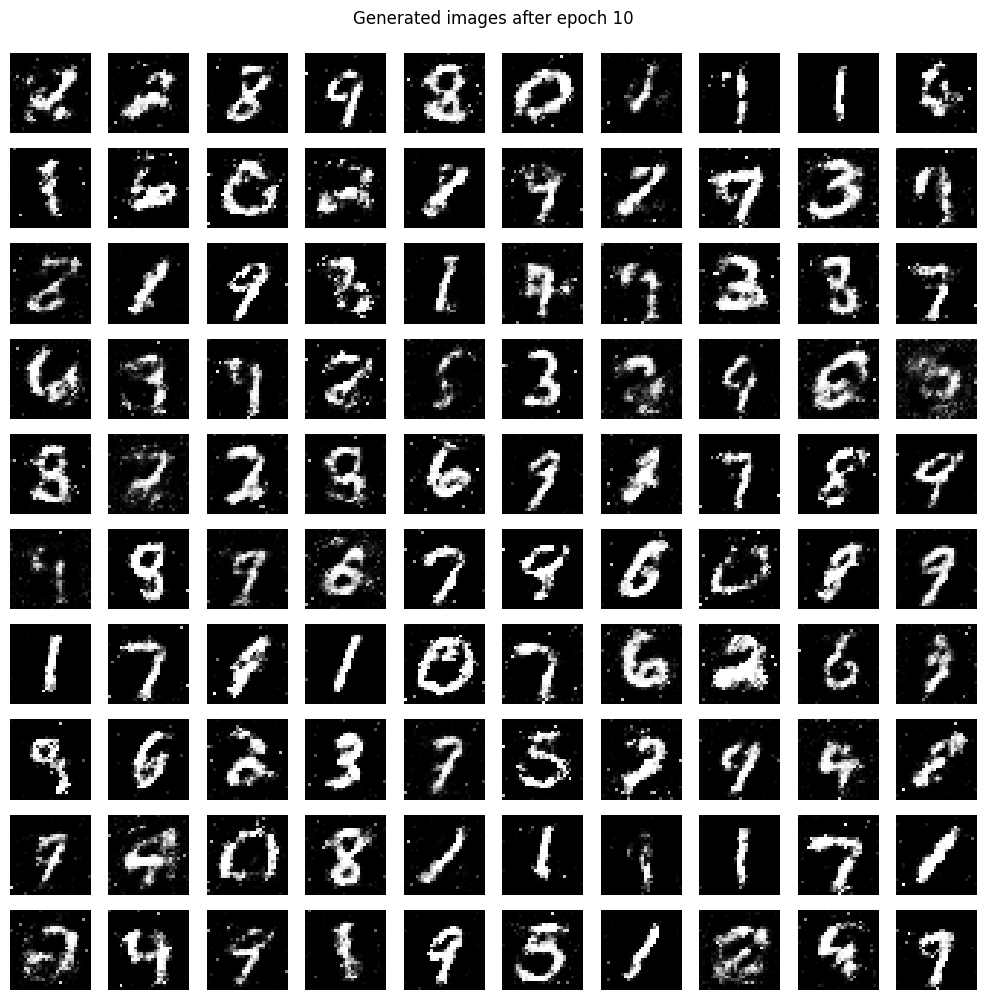


Epoch 11/50
Batch 400, D Loss: 1.0905, G Loss: 1.2065
Epoch 12/50
Batch 400, D Loss: 1.2173, G Loss: 1.3637
Epoch 13/50
Batch 400, D Loss: 1.2061, G Loss: 1.1347
Epoch 14/50
Batch 400, D Loss: 1.1928, G Loss: 1.0190
Epoch 15/50
Batch 400, D Loss: 1.2605, G Loss: 0.9990
Epoch 16/50
Batch 400, D Loss: 1.2443, G Loss: 1.0539
Epoch 17/50
Batch 400, D Loss: 1.2148, G Loss: 1.0225
Epoch 18/50
Batch 400, D Loss: 1.2529, G Loss: 1.0704
Epoch 19/50
Batch 400, D Loss: 1.2782, G Loss: 0.9839
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


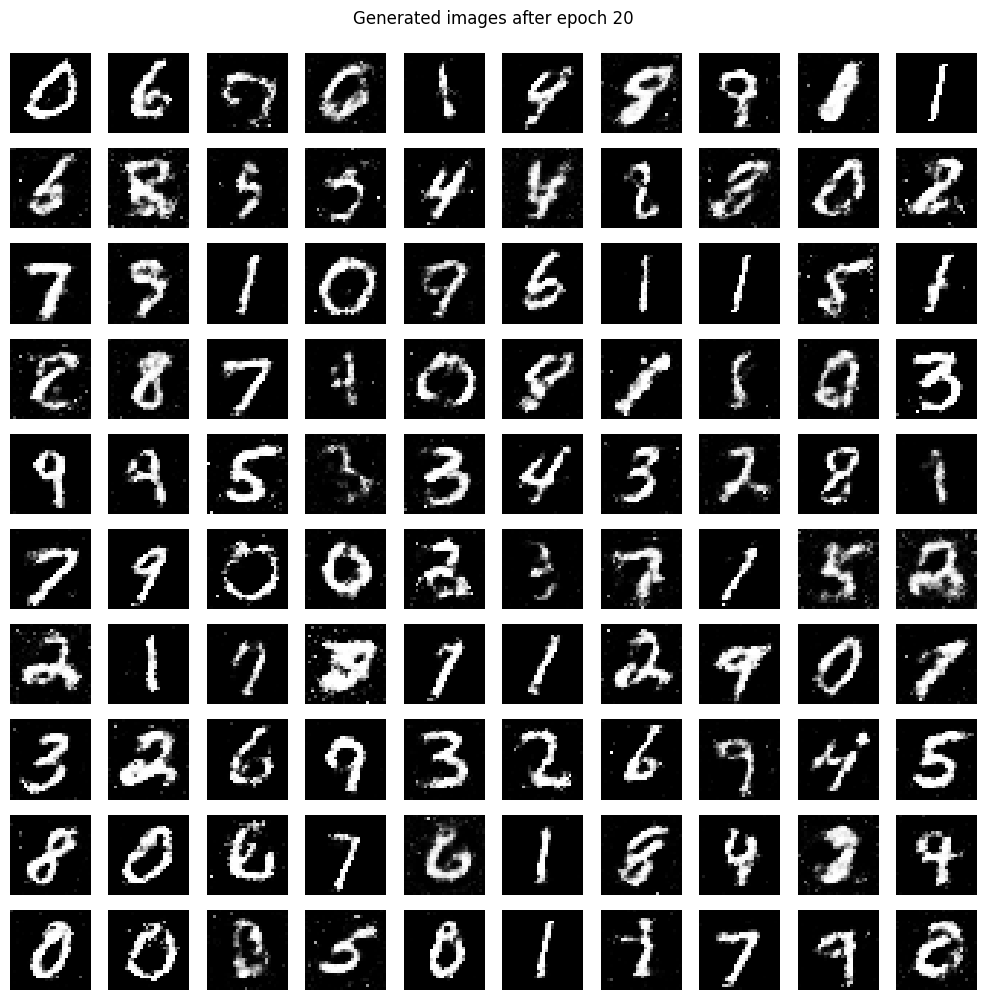


Epoch 21/50
Batch 400, D Loss: 1.2780, G Loss: 0.9663
Epoch 22/50
Batch 400, D Loss: 1.3549, G Loss: 0.9989
Epoch 23/50
Batch 400, D Loss: 1.2122, G Loss: 1.0414
Epoch 24/50
Batch 400, D Loss: 1.3158, G Loss: 1.0292
Epoch 25/50
Batch 400, D Loss: 1.2189, G Loss: 1.0168
Epoch 26/50
Batch 400, D Loss: 1.3652, G Loss: 0.9688
Epoch 27/50
Batch 400, D Loss: 1.3114, G Loss: 0.9615
Epoch 28/50
Batch 400, D Loss: 1.2448, G Loss: 0.9352
Epoch 29/50
Batch 400, D Loss: 1.3154, G Loss: 0.8871
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


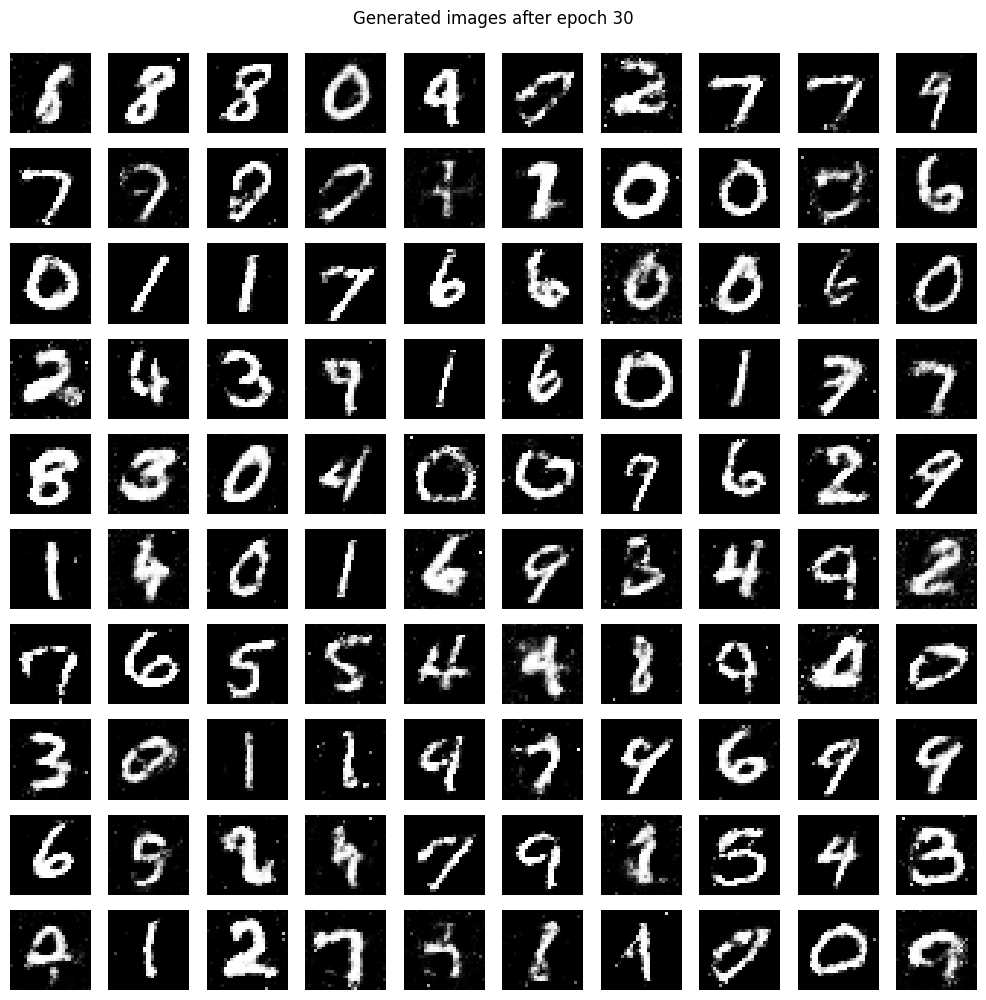


Epoch 31/50
Batch 400, D Loss: 1.3042, G Loss: 0.9155
Epoch 32/50
Batch 400, D Loss: 1.2354, G Loss: 0.9646
Epoch 33/50
Batch 400, D Loss: 1.2990, G Loss: 0.8636
Epoch 34/50
Batch 400, D Loss: 1.2736, G Loss: 0.9842
Epoch 35/50
Batch 400, D Loss: 1.3243, G Loss: 1.1180
Epoch 36/50
Batch 400, D Loss: 1.2877, G Loss: 0.8501
Epoch 37/50
Batch 400, D Loss: 1.3700, G Loss: 0.9213
Epoch 38/50
Batch 400, D Loss: 1.3375, G Loss: 0.9685
Epoch 39/50
Batch 400, D Loss: 1.2847, G Loss: 0.9451
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


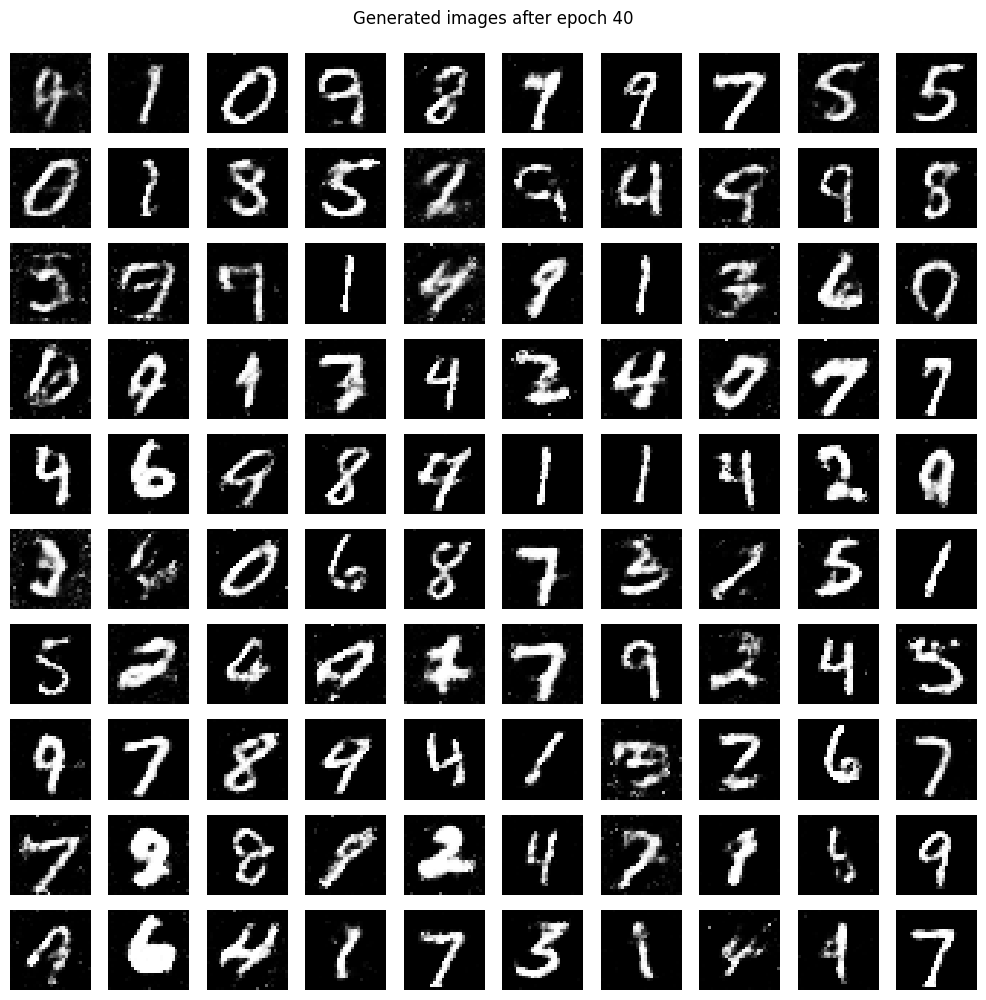


Epoch 41/50
Batch 400, D Loss: 1.2815, G Loss: 1.0298
Epoch 42/50
Batch 400, D Loss: 1.3584, G Loss: 0.9228
Epoch 43/50
Batch 400, D Loss: 1.3147, G Loss: 1.0221
Epoch 44/50
Batch 400, D Loss: 1.3044, G Loss: 0.9139
Epoch 45/50
Batch 400, D Loss: 1.3121, G Loss: 0.9563
Epoch 46/50
Batch 400, D Loss: 1.3098, G Loss: 0.9099
Epoch 47/50
Batch 400, D Loss: 1.3641, G Loss: 0.8866
Epoch 48/50
Batch 400, D Loss: 1.2938, G Loss: 1.0347
Epoch 49/50
Batch 400, D Loss: 1.3690, G Loss: 1.0384
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


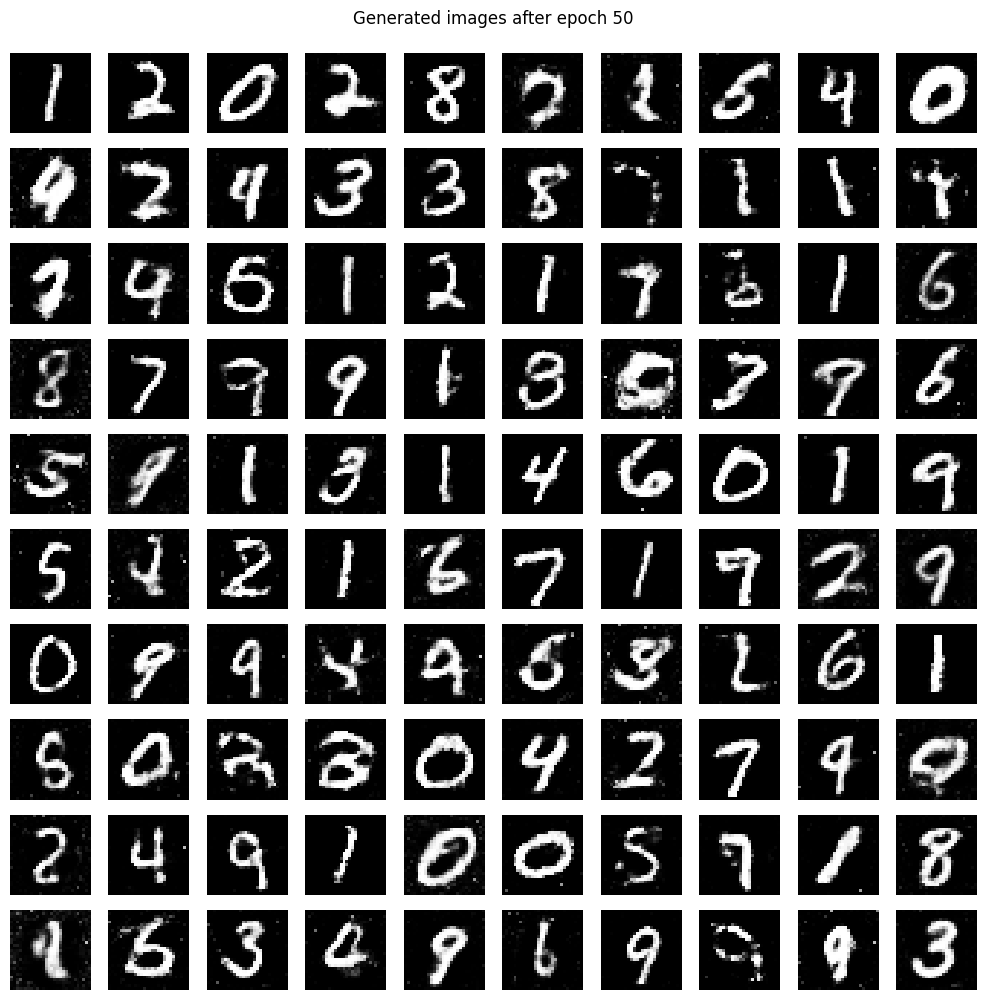

In [9]:
train(epochs=50, batch_size=128)

## Assignment
### PART-1:

Modify the discriminator based on the following:

1. Use at least 2 convolutional layers in the discriminator.
2. Do not use dense layers, except for the output layer.
2. The input should be 2D image of size 28x28 (You can use Reshape layer of Keras to get correct shaped input from the discriminator).

Re-train your GAN and make sure that you get similar quality output images as the original GAN.

### PART-2:

Now, modify the generator as well, so that the whole GAN becomes a convolutional neural network:

1. Use at least 2 convolutional layers in the generator. You may also like to use batch normalization layers after each convolutional layer. Try using ReLU or Leaky ReLU for activation.
2. Do not use any dense layers.
2. The input should be 2D noise image of size 10x10 (You can use Transposed convolution layer of Keras (Conv2DTranspose) to go from 10x10 sized input to 28x28 sized output).

Re-train your GAN and make sure that you get similar quality output images as the original GAN.

Finally, compare the three GAN networks in terms of complexity (training/testing times and total number of trainable parameters) and quality of generated images of digits. Which approach (convolutional or fully connected network) is preferable?


### PART-1 Modify discriminator

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Dropout, Reshape, Flatten, Dense

def create_discriminator_part1():
    discriminator = Sequential()

    # from 784 to 28x28
    discriminator.add(Reshape((28, 28, 1), input_shape=(784,)))

    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return discriminator


In [11]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_part1()

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/50
Batch 400, D Loss: 1.4480, G Loss: 1.8643
Epoch 2/50
Batch 400, D Loss: 1.4232, G Loss: 2.2664
Epoch 3/50
Batch 400, D Loss: 0.2768, G Loss: 3.1362
Epoch 4/50
Batch 400, D Loss: 0.5370, G Loss: 4.0447
Epoch 5/50
Batch 400, D Loss: 0.3612, G Loss: 3.8688
Epoch 6/50
Batch 400, D Loss: 0.1949, G Loss: 3.9810
Epoch 7/50
Batch 400, D Loss: 0.2334, G Loss: 4.5334
Epoch 8/50
Batch 400, D Loss: 0.5476, G Loss: 3.7131
Epoch 9/50
Batch 400, D Loss: 0.4357, G Loss: 3.8811
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


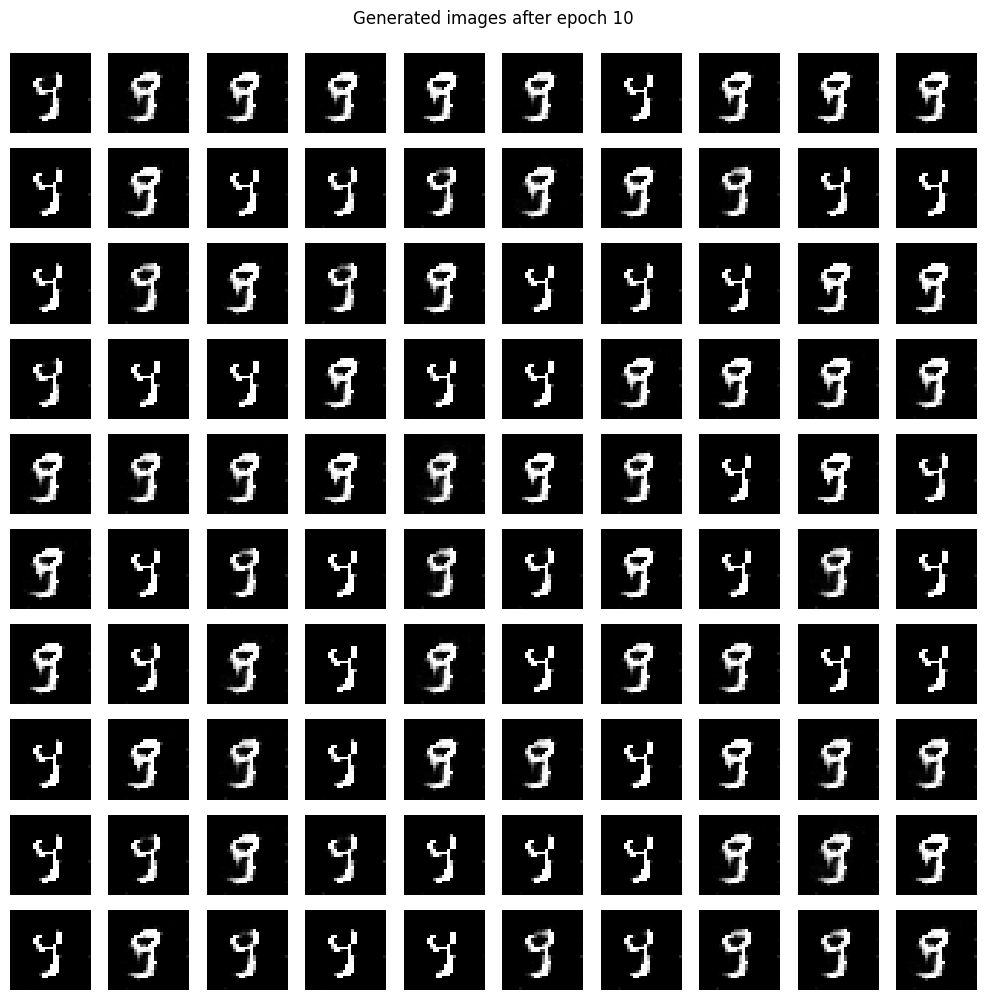


Epoch 11/50
Batch 400, D Loss: 0.2542, G Loss: 5.1163
Epoch 12/50
Batch 400, D Loss: 0.2718, G Loss: 4.5457
Epoch 13/50
Batch 400, D Loss: 0.1719, G Loss: 5.0073
Epoch 14/50
Batch 400, D Loss: 0.1690, G Loss: 4.2340
Epoch 15/50
Batch 400, D Loss: 0.4137, G Loss: 5.7899
Epoch 16/50
Batch 400, D Loss: 0.8383, G Loss: 3.1260
Epoch 17/50
Batch 400, D Loss: 0.0942, G Loss: 5.9054
Epoch 18/50
Batch 400, D Loss: 0.2828, G Loss: 4.3987
Epoch 19/50
Batch 400, D Loss: 0.1605, G Loss: 5.5946
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


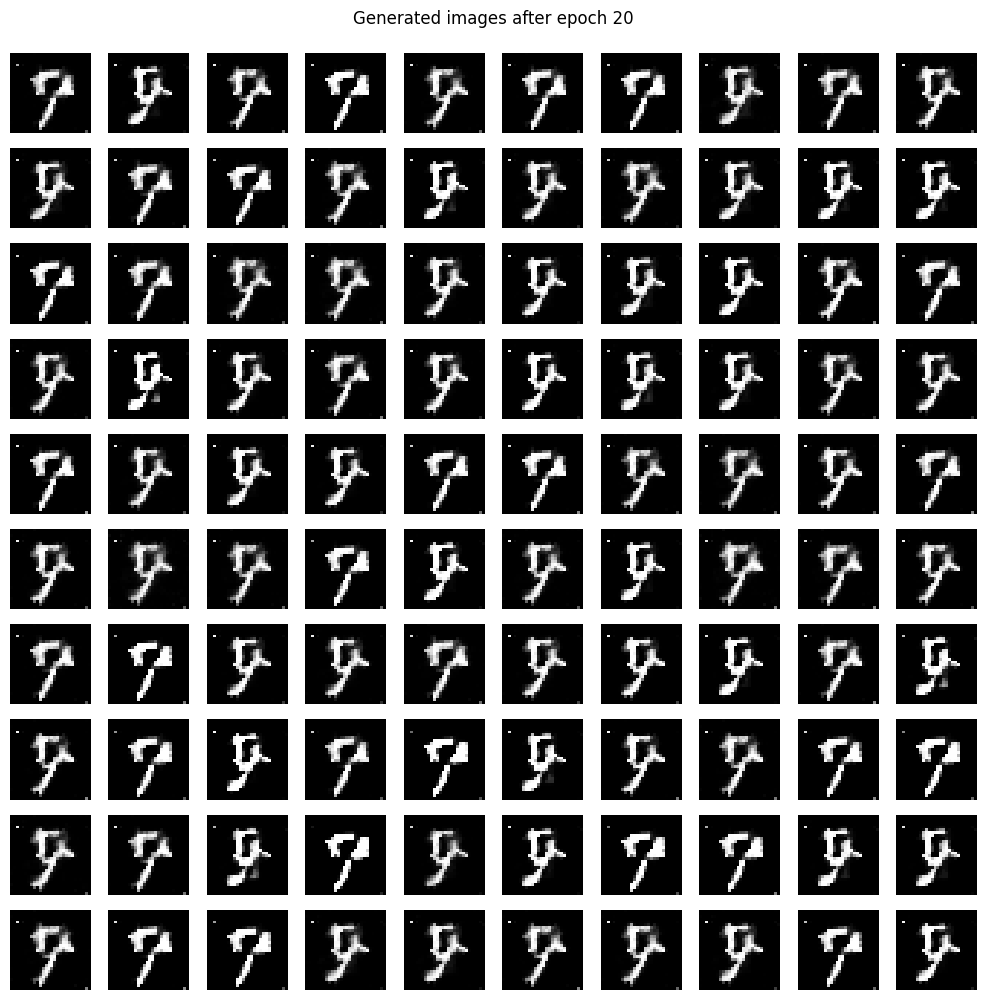


Epoch 21/50
Batch 400, D Loss: 0.1672, G Loss: 5.3707
Epoch 22/50
Batch 400, D Loss: 0.0821, G Loss: 5.5578
Epoch 23/50
Batch 400, D Loss: 0.3687, G Loss: 3.3701
Epoch 24/50
Batch 400, D Loss: 0.4123, G Loss: 3.5957
Epoch 25/50
Batch 400, D Loss: 0.1497, G Loss: 4.2075
Epoch 26/50
Batch 400, D Loss: 0.2316, G Loss: 3.4118
Epoch 27/50
Batch 400, D Loss: 0.3609, G Loss: 3.7105
Epoch 28/50
Batch 400, D Loss: 0.2052, G Loss: 4.3096
Epoch 29/50
Batch 400, D Loss: 0.2709, G Loss: 3.7709
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


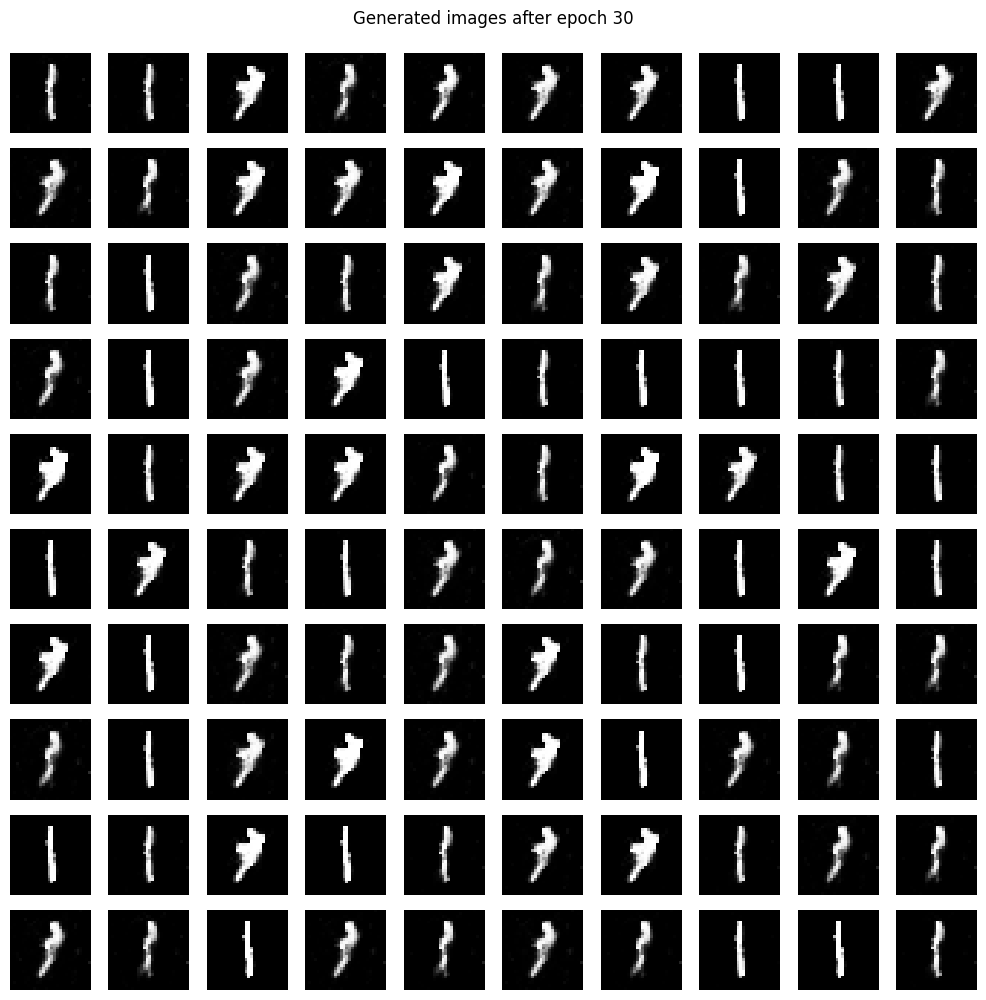


Epoch 31/50
Batch 400, D Loss: 0.3244, G Loss: 3.7890
Epoch 32/50
Batch 400, D Loss: 0.3553, G Loss: 3.4409
Epoch 33/50
Batch 400, D Loss: 0.5358, G Loss: 3.3892
Epoch 34/50
Batch 400, D Loss: 0.3762, G Loss: 3.4900
Epoch 35/50
Batch 400, D Loss: 0.3325, G Loss: 3.7451
Epoch 36/50
Batch 400, D Loss: 0.4132, G Loss: 2.8752
Epoch 37/50
Batch 400, D Loss: 0.1993, G Loss: 3.8627
Epoch 38/50
Batch 400, D Loss: 0.2576, G Loss: 3.4993
Epoch 39/50
Batch 400, D Loss: 0.3613, G Loss: 3.3011
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


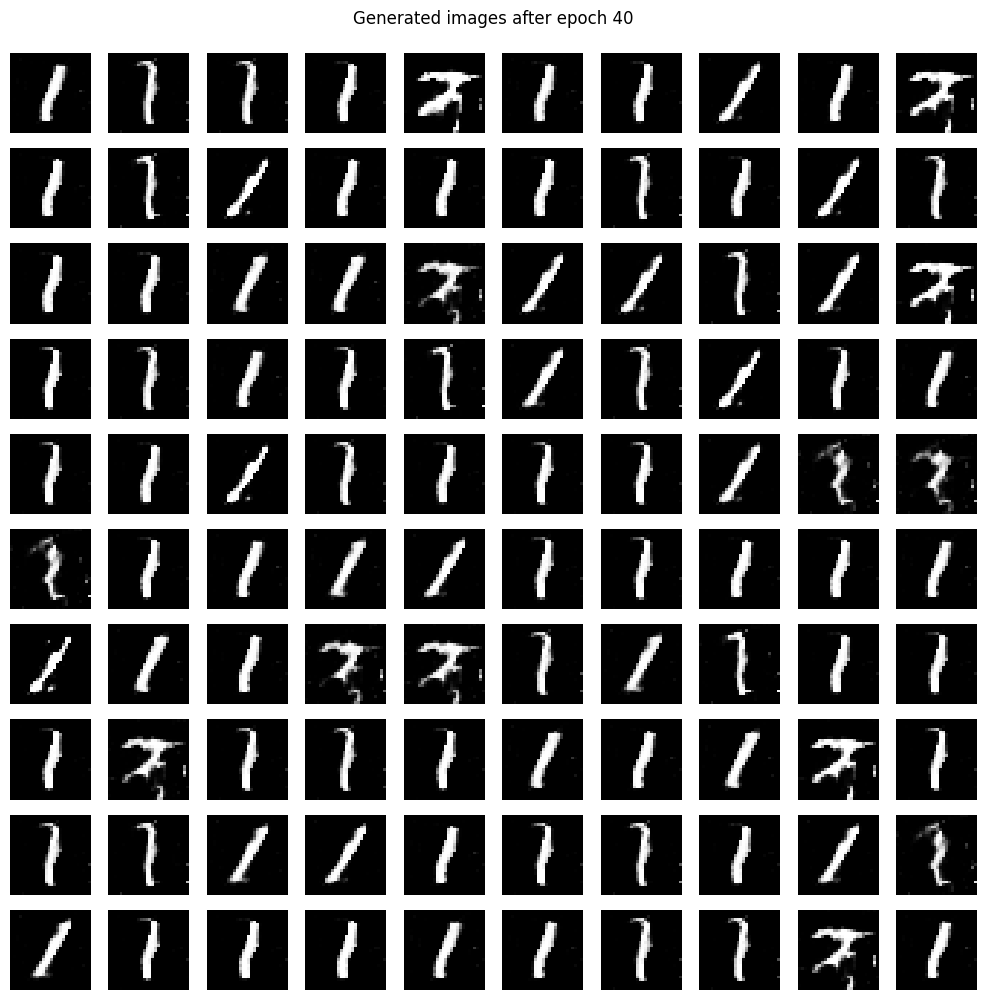


Epoch 41/50
Batch 400, D Loss: 0.3656, G Loss: 3.1234
Epoch 42/50
Batch 400, D Loss: 0.4687, G Loss: 3.5930
Epoch 43/50
Batch 400, D Loss: 0.3462, G Loss: 3.7305
Epoch 44/50
Batch 400, D Loss: 0.3042, G Loss: 3.6858
Epoch 45/50
Batch 400, D Loss: 0.3408, G Loss: 3.5590
Epoch 46/50
Batch 400, D Loss: 0.3370, G Loss: 3.8042
Epoch 47/50
Batch 400, D Loss: 0.4148, G Loss: 3.4908
Epoch 48/50
Batch 400, D Loss: 0.3568, G Loss: 3.0987
Epoch 49/50
Batch 400, D Loss: 0.2632, G Loss: 3.4548
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


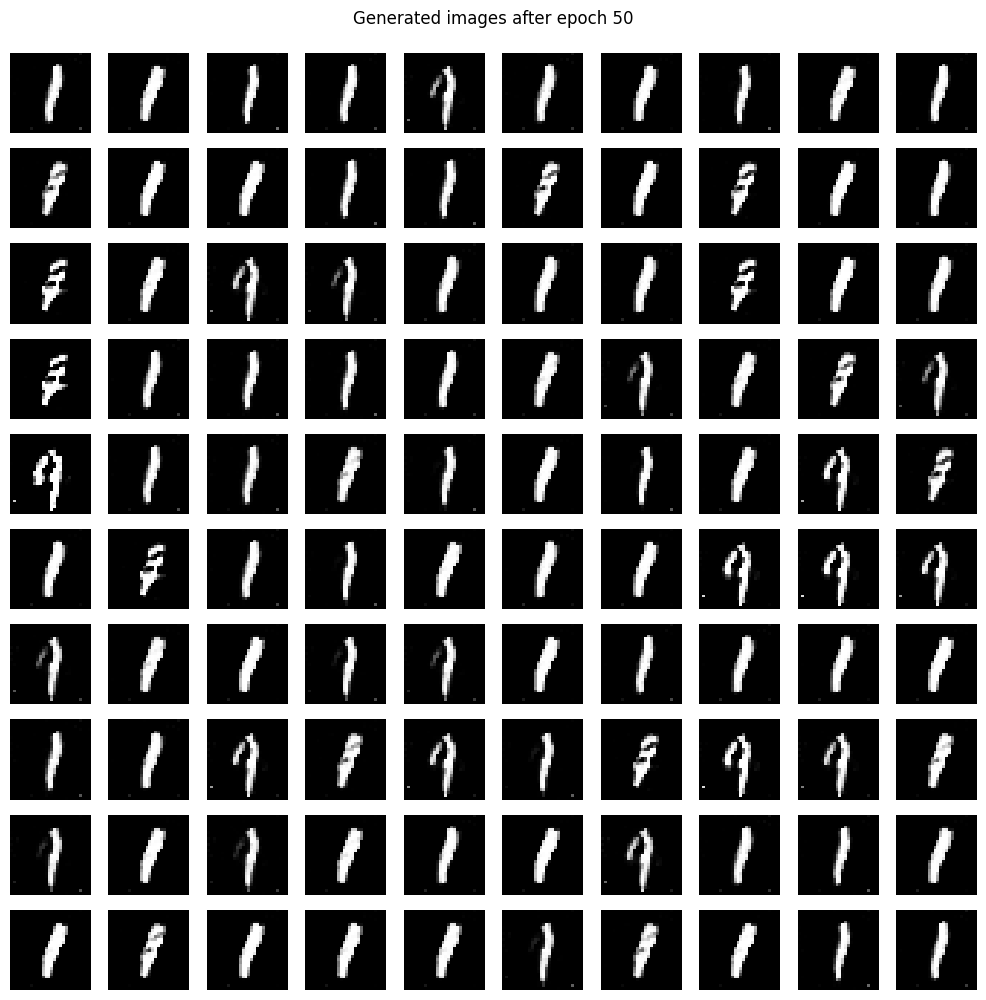

In [12]:
train(epochs=50, batch_size=128)

With 3 Conv layer, model cannot generate numbers clearly

In [13]:
def create_discriminator_with_4_conv():
    discriminator = Sequential()

    discriminator.add(Reshape((28, 28, 1), input_shape=(784,)))

    discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return discriminator


In [14]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_with_4_conv()

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/50
Batch 400, D Loss: 0.7166, G Loss: 2.2476
Epoch 2/50
Batch 400, D Loss: 0.1551, G Loss: 4.5115
Epoch 3/50
Batch 400, D Loss: 0.1484, G Loss: 8.0134
Epoch 4/50
Batch 400, D Loss: 0.0845, G Loss: 7.1982
Epoch 5/50
Batch 400, D Loss: 0.2740, G Loss: 4.4023
Epoch 6/50
Batch 400, D Loss: 0.1171, G Loss: 6.8003
Epoch 7/50
Batch 400, D Loss: 0.0162, G Loss: 7.8606
Epoch 8/50
Batch 400, D Loss: 0.0771, G Loss: 7.3027
Epoch 9/50
Batch 400, D Loss: 0.1040, G Loss: 5.5553
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


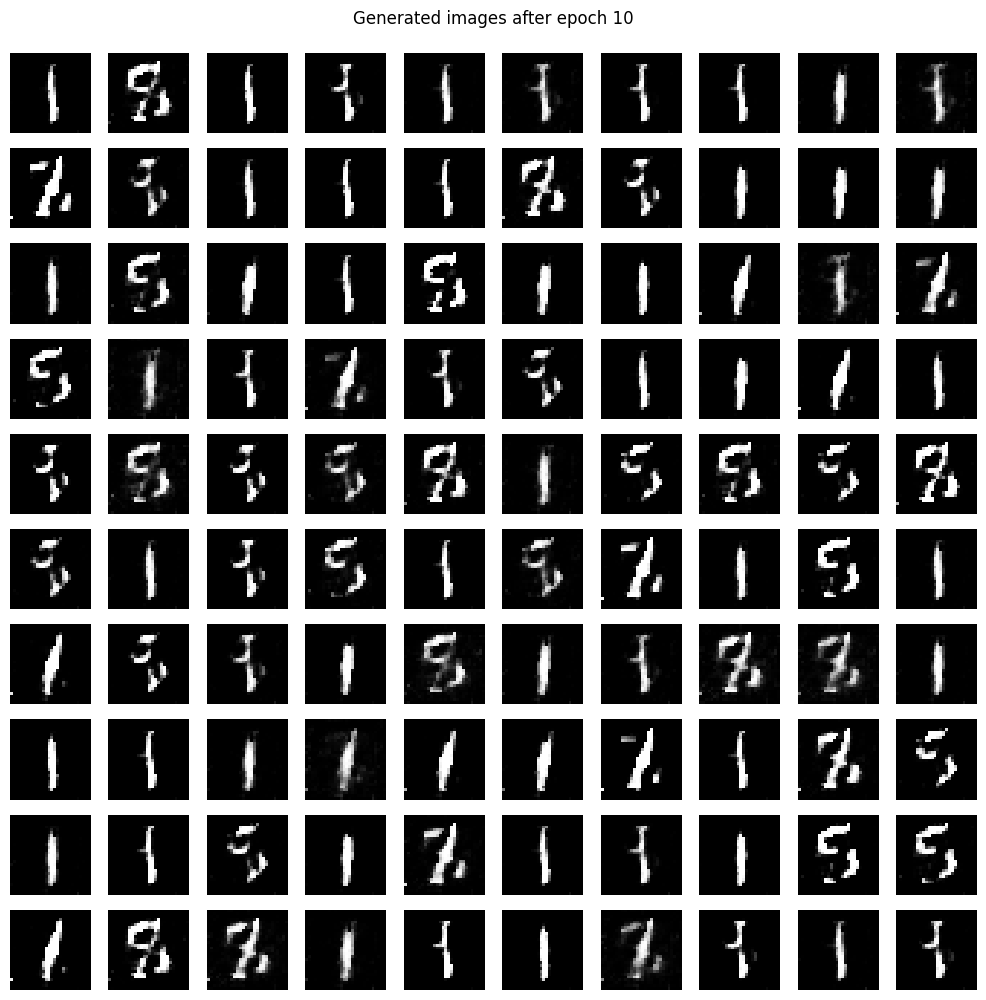


Epoch 11/50
Batch 400, D Loss: 0.4000, G Loss: 3.3869
Epoch 12/50
Batch 400, D Loss: 0.4300, G Loss: 3.0179
Epoch 13/50
Batch 400, D Loss: 0.1936, G Loss: 3.0470
Epoch 14/50
Batch 400, D Loss: 0.2428, G Loss: 2.8288
Epoch 15/50
Batch 400, D Loss: 0.3966, G Loss: 2.4250
Epoch 16/50
Batch 400, D Loss: 0.3896, G Loss: 2.6776
Epoch 17/50
Batch 400, D Loss: 0.3911, G Loss: 2.5716
Epoch 18/50
Batch 400, D Loss: 0.3534, G Loss: 2.5112
Epoch 19/50
Batch 400, D Loss: 0.4997, G Loss: 2.5401
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


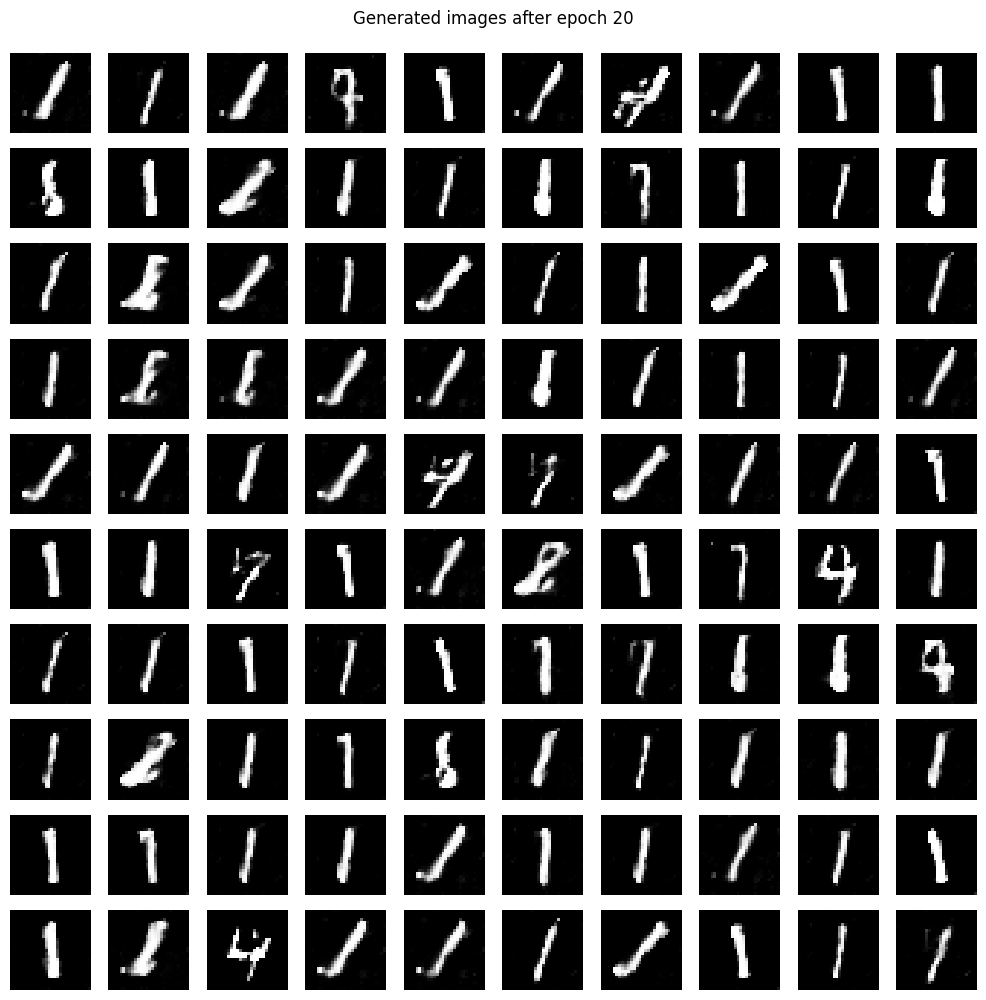


Epoch 21/50
Batch 400, D Loss: 0.4375, G Loss: 2.1827
Epoch 22/50
Batch 400, D Loss: 0.3848, G Loss: 2.2616
Epoch 23/50
Batch 400, D Loss: 0.3549, G Loss: 2.3834
Epoch 24/50
Batch 400, D Loss: 0.5399, G Loss: 2.1664
Epoch 25/50
Batch 400, D Loss: 0.4064, G Loss: 2.6193
Epoch 26/50
Batch 400, D Loss: 0.5269, G Loss: 2.0928
Epoch 27/50
Batch 400, D Loss: 0.6258, G Loss: 2.4270
Epoch 28/50
Batch 400, D Loss: 0.4776, G Loss: 2.2004
Epoch 29/50
Batch 400, D Loss: 0.5254, G Loss: 2.4917
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


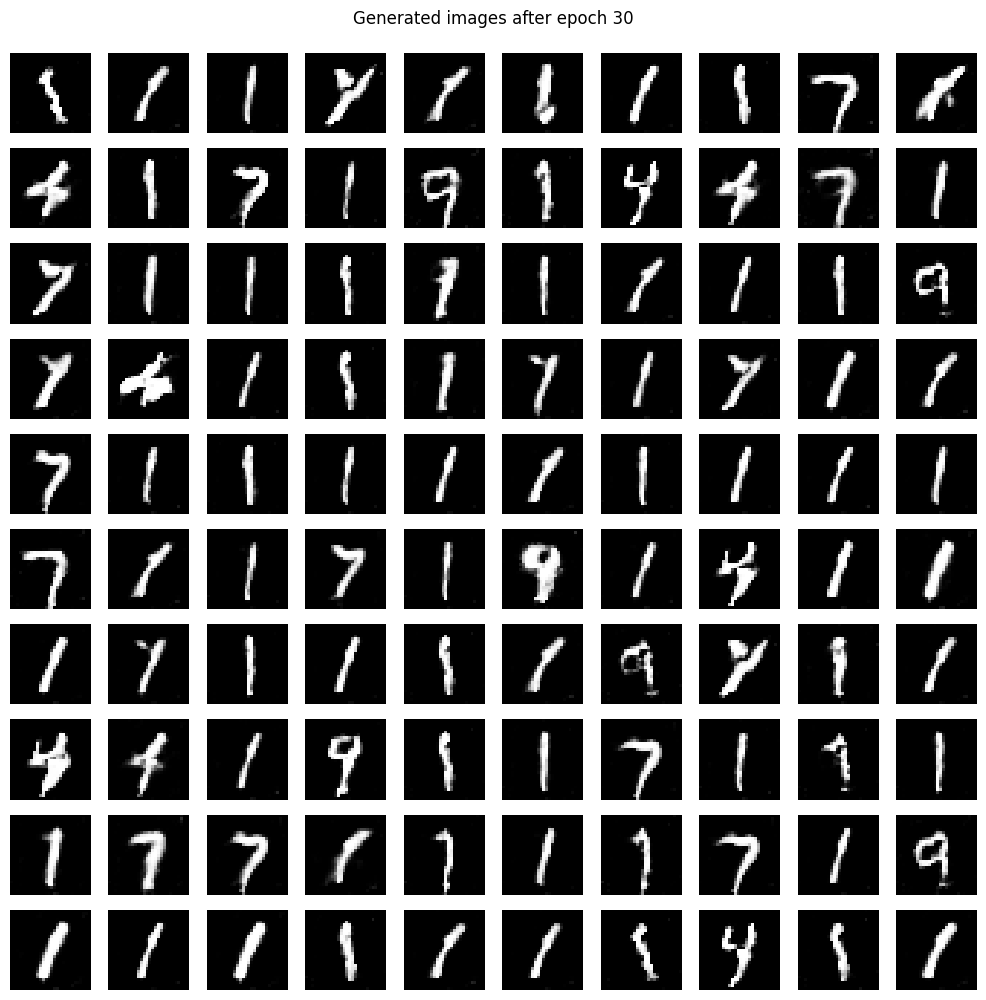


Epoch 31/50
Batch 400, D Loss: 0.4782, G Loss: 2.5073
Epoch 32/50
Batch 400, D Loss: 0.5052, G Loss: 2.4161
Epoch 33/50
Batch 400, D Loss: 0.5166, G Loss: 2.3528
Epoch 34/50
Batch 400, D Loss: 0.6382, G Loss: 2.2123
Epoch 35/50
Batch 400, D Loss: 0.5607, G Loss: 2.6770
Epoch 36/50
Batch 400, D Loss: 0.4877, G Loss: 2.2612
Epoch 37/50
Batch 400, D Loss: 0.6036, G Loss: 2.2886
Epoch 38/50
Batch 400, D Loss: 0.5384, G Loss: 2.3637
Epoch 39/50
Batch 400, D Loss: 0.5853, G Loss: 2.1072
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


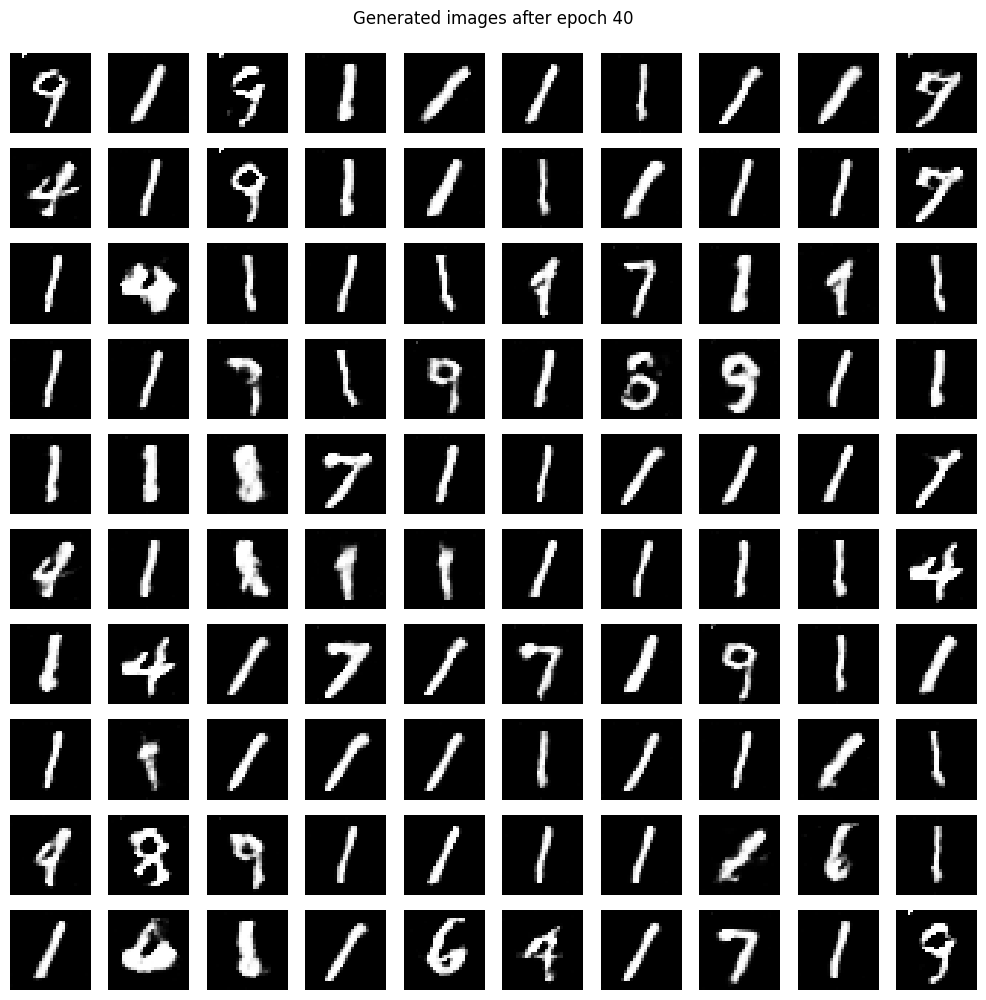


Epoch 41/50
Batch 400, D Loss: 0.6668, G Loss: 2.1439
Epoch 42/50
Batch 400, D Loss: 0.6826, G Loss: 2.2617
Epoch 43/50
Batch 400, D Loss: 0.5685, G Loss: 2.2131
Epoch 44/50
Batch 400, D Loss: 0.5804, G Loss: 2.4101
Epoch 45/50
Batch 400, D Loss: 0.6525, G Loss: 2.2418
Epoch 46/50
Batch 400, D Loss: 0.7754, G Loss: 2.4826
Epoch 47/50
Batch 400, D Loss: 0.5451, G Loss: 2.0923
Epoch 48/50
Batch 400, D Loss: 0.6822, G Loss: 2.6739
Epoch 49/50
Batch 400, D Loss: 0.5395, G Loss: 2.2211
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


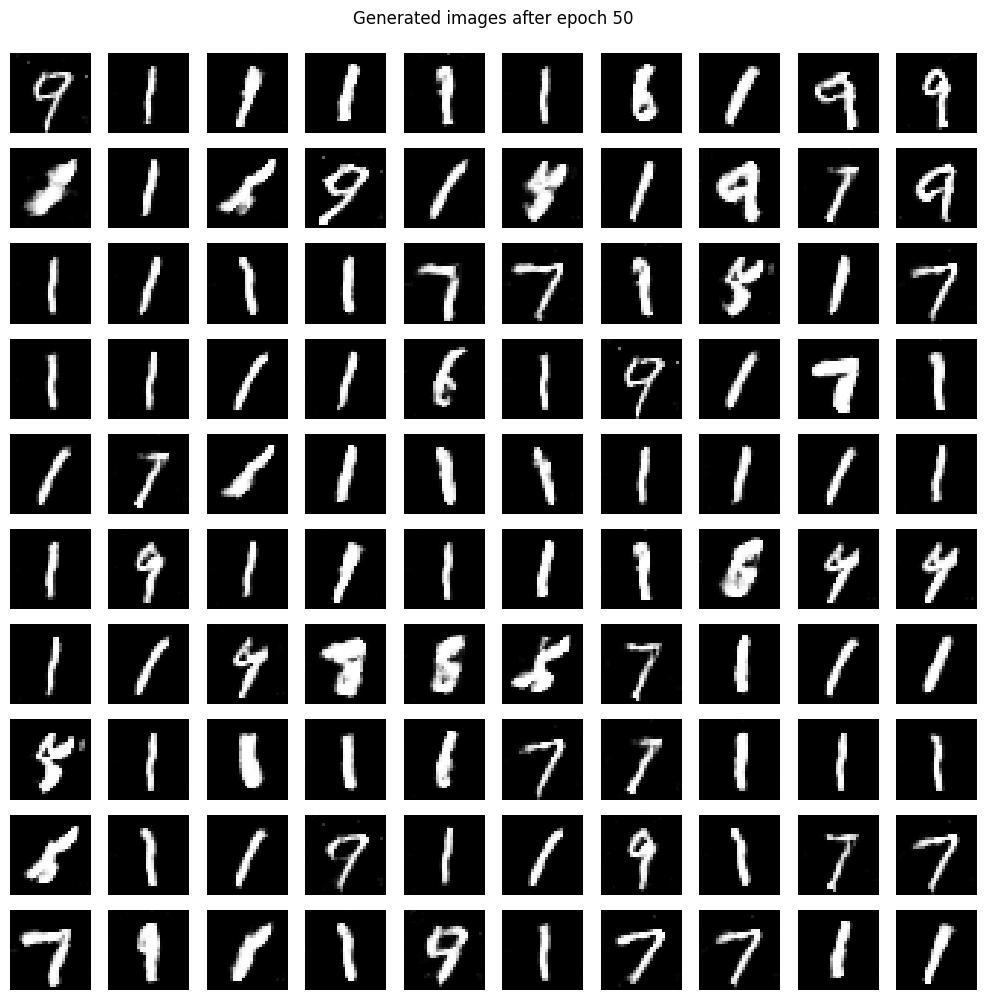

In [15]:
train(epochs=50, batch_size=128)

In [48]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

def create_discriminator_part1_conv2():
    discriminator = Sequential()
    discriminator.add(Reshape((28, 28, 1), input_shape=(784,)))

    discriminator.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Flatten())

    discriminator.add(layers.Dense(256))
    discriminator.add(layers.LeakyReLU(0.2))

    discriminator.add(layers.Dense(1, activation='sigmoid'))  # Output layer to predict real/fake

    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    return discriminator


In [49]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_part1_conv2()

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/50
Batch 400, D Loss: 0.6176, G Loss: 2.9345
Epoch 2/50
Batch 400, D Loss: 0.2896, G Loss: 3.2948
Epoch 3/50
Batch 400, D Loss: 0.3574, G Loss: 4.5833
Epoch 4/50
Batch 400, D Loss: 0.1246, G Loss: 4.7272
Epoch 5/50
Batch 400, D Loss: 0.2122, G Loss: 5.4051
Epoch 6/50
Batch 400, D Loss: 0.1717, G Loss: 4.7658
Epoch 7/50
Batch 400, D Loss: 0.1146, G Loss: 6.0891
Epoch 8/50
Batch 400, D Loss: 0.0630, G Loss: 5.7298
Epoch 9/50
Batch 400, D Loss: 0.1148, G Loss: 5.9603
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


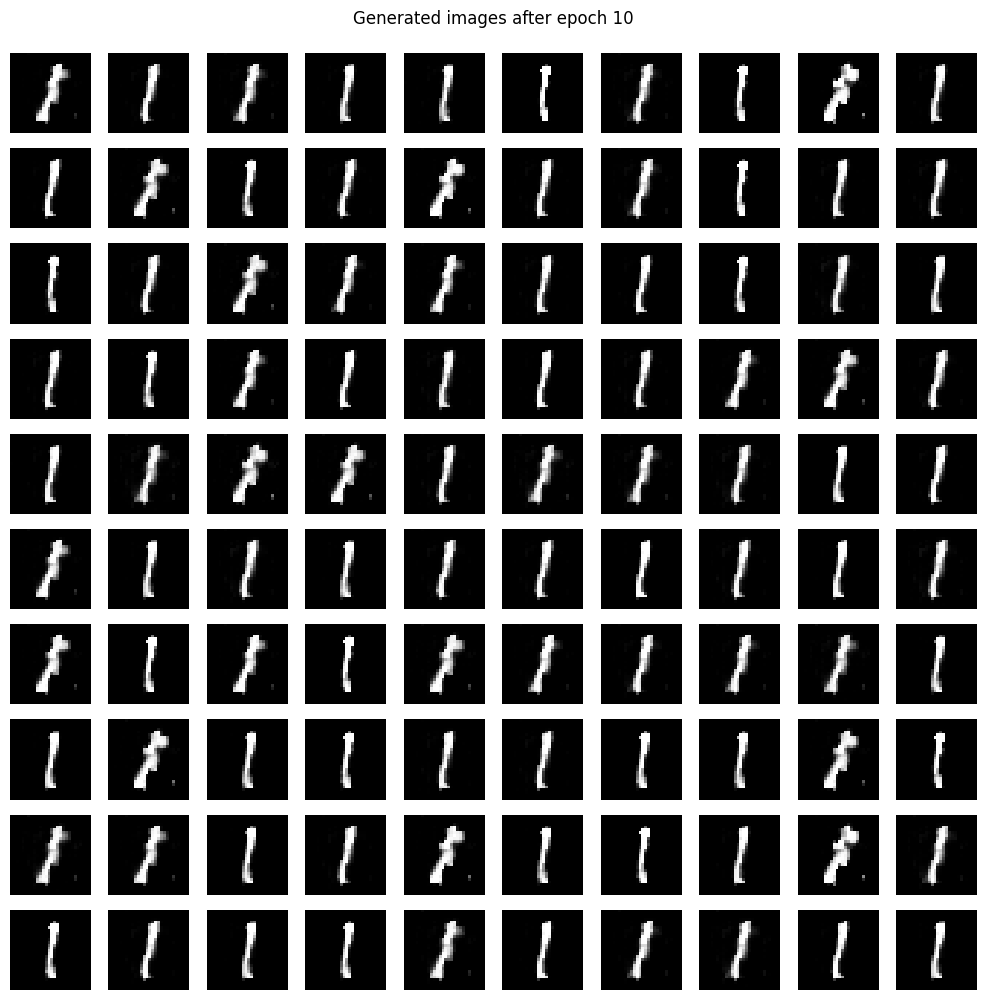


Epoch 11/50
Batch 400, D Loss: 0.1673, G Loss: 3.9746
Epoch 12/50
Batch 400, D Loss: 0.1564, G Loss: 4.6044
Epoch 13/50
Batch 400, D Loss: 0.1444, G Loss: 3.9784
Epoch 14/50
Batch 400, D Loss: 0.2101, G Loss: 4.1208
Epoch 15/50
Batch 400, D Loss: 0.3292, G Loss: 3.1111
Epoch 16/50
Batch 400, D Loss: 0.2628, G Loss: 4.0918
Epoch 17/50
Batch 400, D Loss: 0.3216, G Loss: 3.0511
Epoch 18/50
Batch 400, D Loss: 0.2943, G Loss: 3.5852
Epoch 19/50
Batch 400, D Loss: 0.3869, G Loss: 3.3006
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


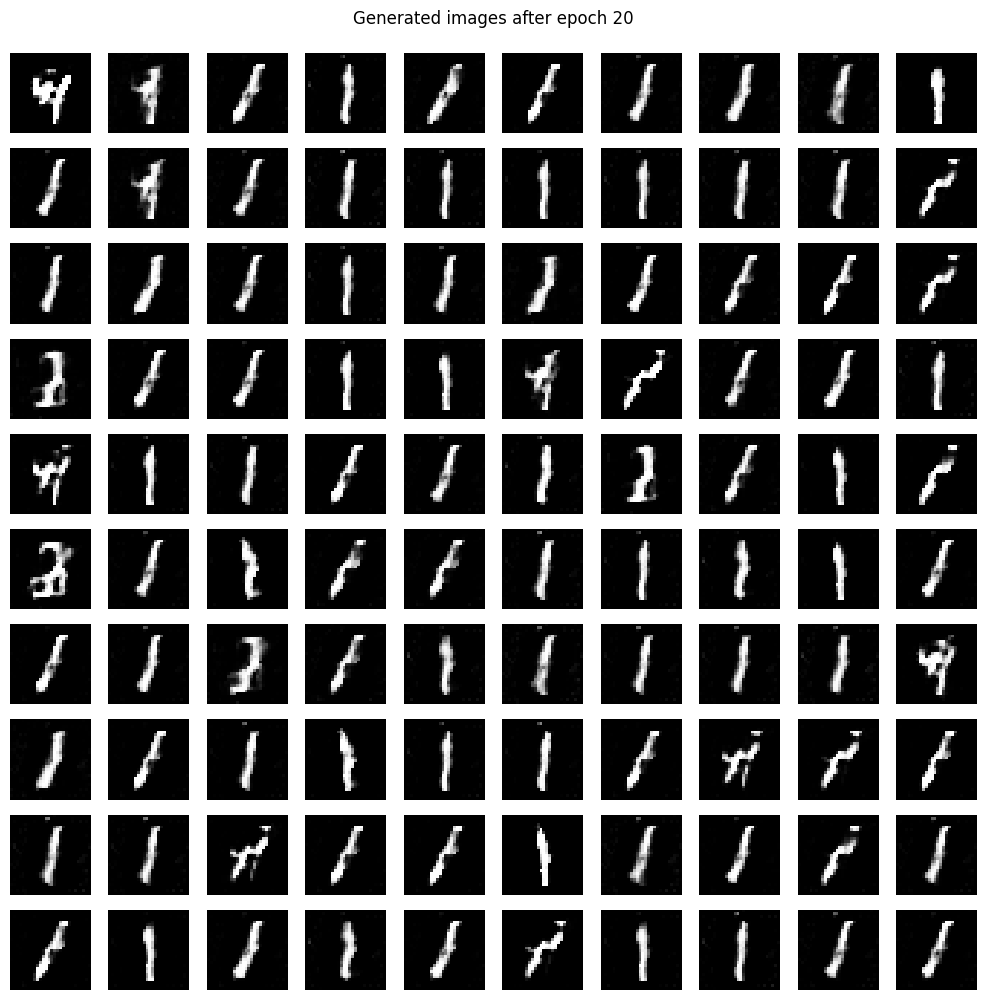


Epoch 21/50
Batch 400, D Loss: 0.2763, G Loss: 2.7350
Epoch 22/50
Batch 400, D Loss: 0.4777, G Loss: 2.4908
Epoch 23/50
Batch 400, D Loss: 0.4237, G Loss: 2.5095
Epoch 24/50
Batch 400, D Loss: 0.4816, G Loss: 3.0445
Epoch 25/50
Batch 400, D Loss: 0.4282, G Loss: 2.5998
Epoch 26/50
Batch 400, D Loss: 0.4230, G Loss: 2.4098
Epoch 27/50
Batch 400, D Loss: 0.4370, G Loss: 2.4068
Epoch 28/50
Batch 400, D Loss: 0.4700, G Loss: 2.6063
Epoch 29/50
Batch 400, D Loss: 0.5485, G Loss: 2.2944
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


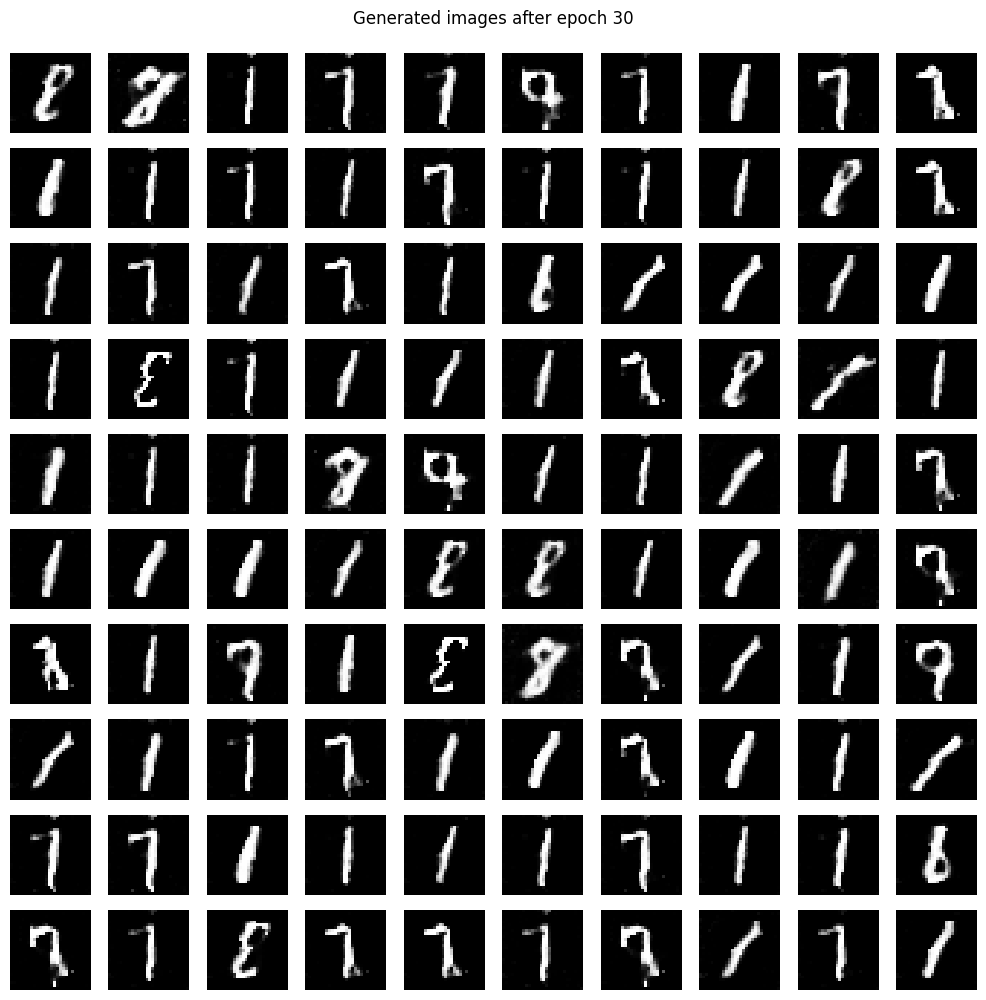


Epoch 31/50
Batch 400, D Loss: 0.5183, G Loss: 2.2893
Epoch 32/50
Batch 400, D Loss: 0.3504, G Loss: 2.5116
Epoch 33/50
Batch 400, D Loss: 0.3818, G Loss: 2.4080
Epoch 34/50
Batch 400, D Loss: 0.3232, G Loss: 3.0976
Epoch 35/50
Batch 400, D Loss: 0.6173, G Loss: 2.4253
Epoch 36/50
Batch 400, D Loss: 0.3842, G Loss: 3.0632
Epoch 37/50
Batch 400, D Loss: 0.3148, G Loss: 3.1675
Epoch 38/50
Batch 400, D Loss: 0.2924, G Loss: 3.1200
Epoch 39/50
Batch 400, D Loss: 0.3238, G Loss: 2.9232
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


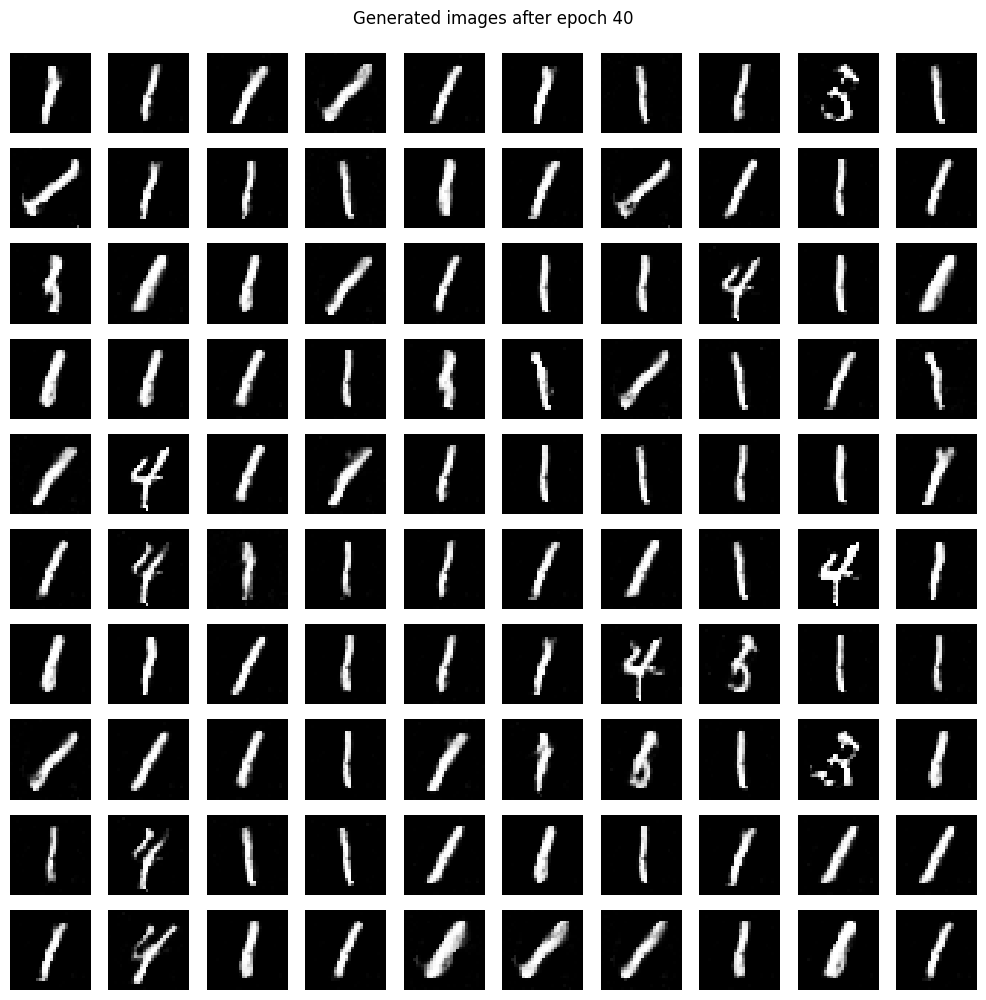


Epoch 41/50
Batch 400, D Loss: 0.5201, G Loss: 2.1081
Epoch 42/50
Batch 400, D Loss: 0.3363, G Loss: 2.8372
Epoch 43/50
Batch 400, D Loss: 0.4125, G Loss: 3.0875
Epoch 44/50
Batch 400, D Loss: 0.5440, G Loss: 2.2611
Epoch 45/50
Batch 400, D Loss: 0.3654, G Loss: 2.6635
Epoch 46/50
Batch 400, D Loss: 0.4341, G Loss: 2.4736
Epoch 47/50
Batch 400, D Loss: 0.4173, G Loss: 2.3963
Epoch 48/50
Batch 400, D Loss: 0.5121, G Loss: 2.6108
Epoch 49/50
Batch 400, D Loss: 0.5407, G Loss: 1.8984
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


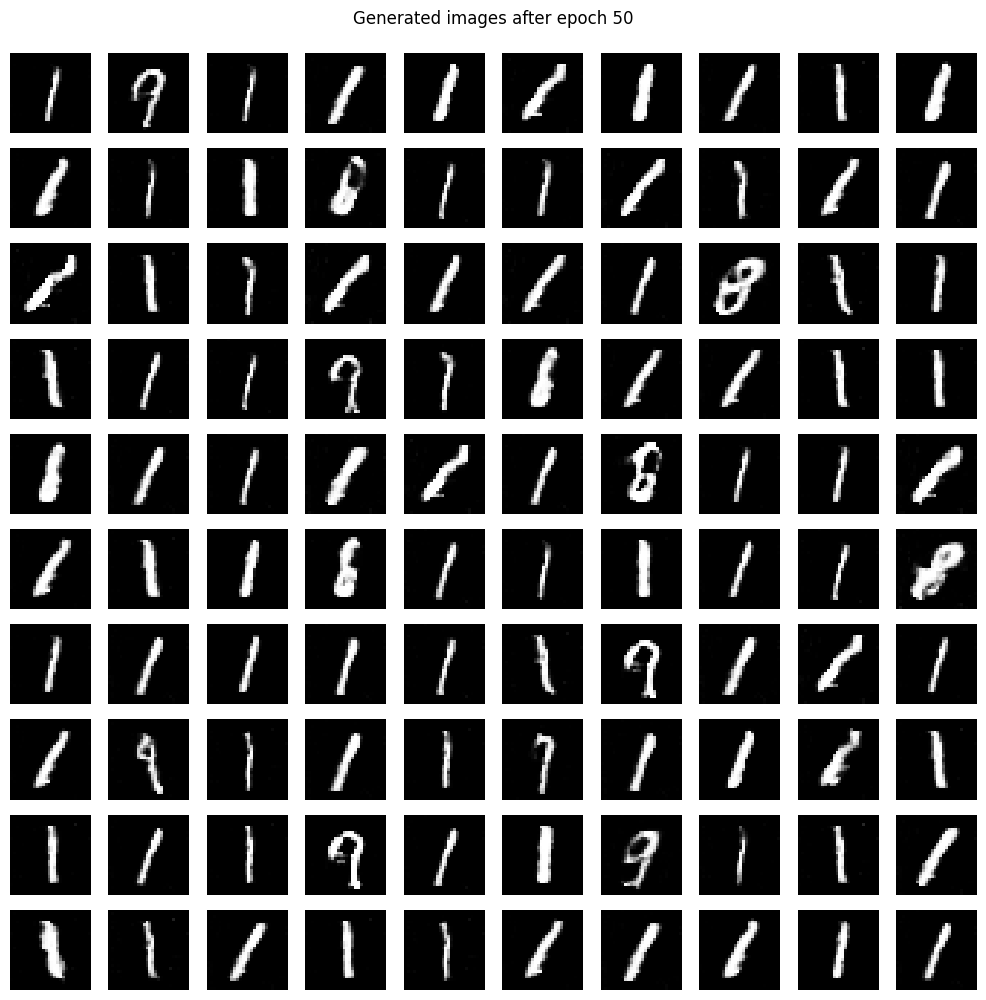

In [50]:
train(epochs=50, batch_size=128)

I think that we need to use fewer complex layers for the discriminator because we didn't change the generator so generated images are not look good.

In [51]:
def create_discriminator_reduced_complexity():
    model = Sequential()
    model.add(Reshape((28, 28, 1), input_shape=(784,)))

    # First convolutional layer
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 1)))
    model.add(LeakyReLU(alpha=0.2))

    # Second convolutional layer with fewer filters
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))  # Output layer

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    return model

In [52]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_reduced_complexity()

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dis


Epoch 1/50
Batch 400, D Loss: 1.1329, G Loss: 0.8460
Epoch 2/50
Batch 400, D Loss: 1.3228, G Loss: 0.7735
Epoch 3/50
Batch 400, D Loss: 1.2202, G Loss: 1.0168
Epoch 4/50
Batch 400, D Loss: 1.5146, G Loss: 0.8418
Epoch 5/50
Batch 400, D Loss: 0.9858, G Loss: 1.0828
Epoch 6/50
Batch 400, D Loss: 1.2715, G Loss: 1.0055
Epoch 7/50
Batch 400, D Loss: 1.2616, G Loss: 0.8808
Epoch 8/50
Batch 400, D Loss: 0.6842, G Loss: 1.4054
Epoch 9/50
Batch 400, D Loss: 0.9185, G Loss: 1.3140
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


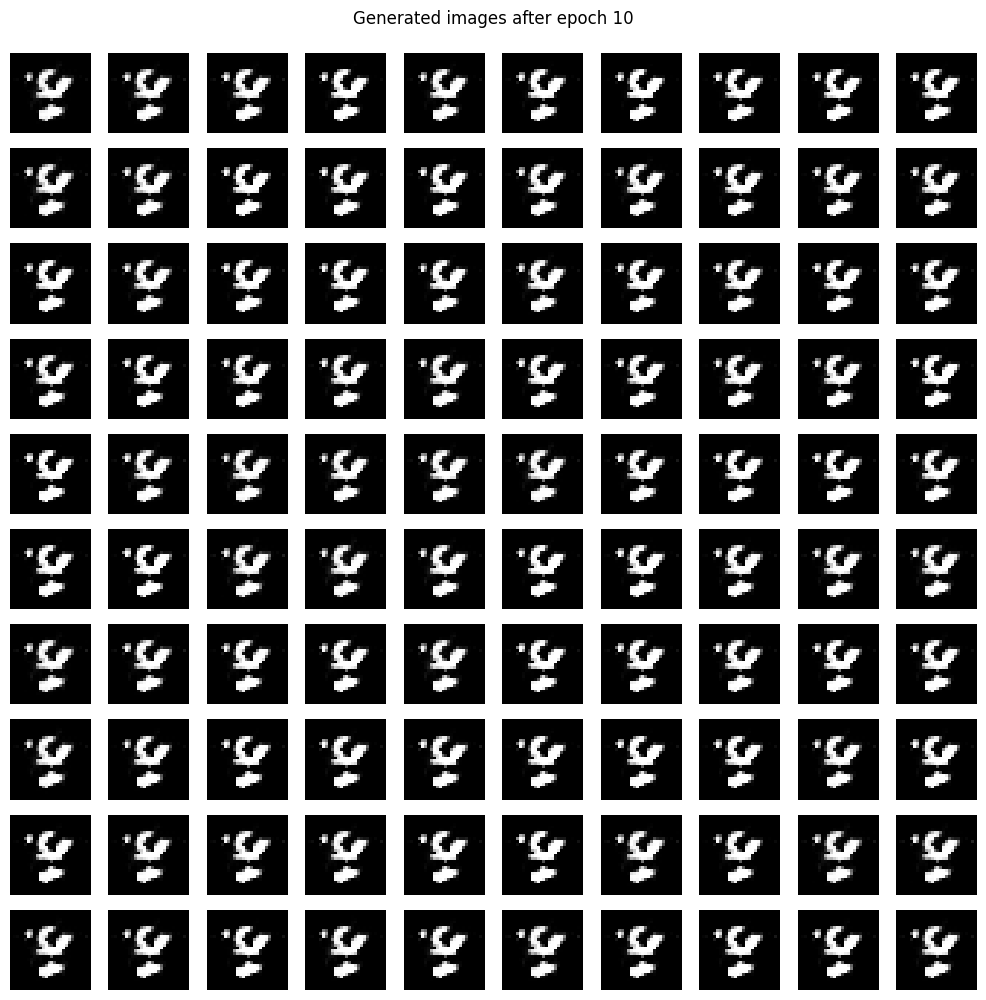


Epoch 11/50
Batch 400, D Loss: 0.8832, G Loss: 1.3232
Epoch 12/50
Batch 400, D Loss: 0.9239, G Loss: 1.5987
Epoch 13/50
Batch 400, D Loss: 1.1247, G Loss: 0.9629
Epoch 14/50
Batch 400, D Loss: 0.8629, G Loss: 1.1907
Epoch 15/50
Batch 400, D Loss: 1.7078, G Loss: 0.6757
Epoch 16/50
Batch 400, D Loss: 0.7827, G Loss: 1.3177
Epoch 17/50
Batch 400, D Loss: 0.9655, G Loss: 1.2824
Epoch 18/50
Batch 400, D Loss: 1.5179, G Loss: 0.8321
Epoch 19/50
Batch 400, D Loss: 1.2370, G Loss: 0.9935
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


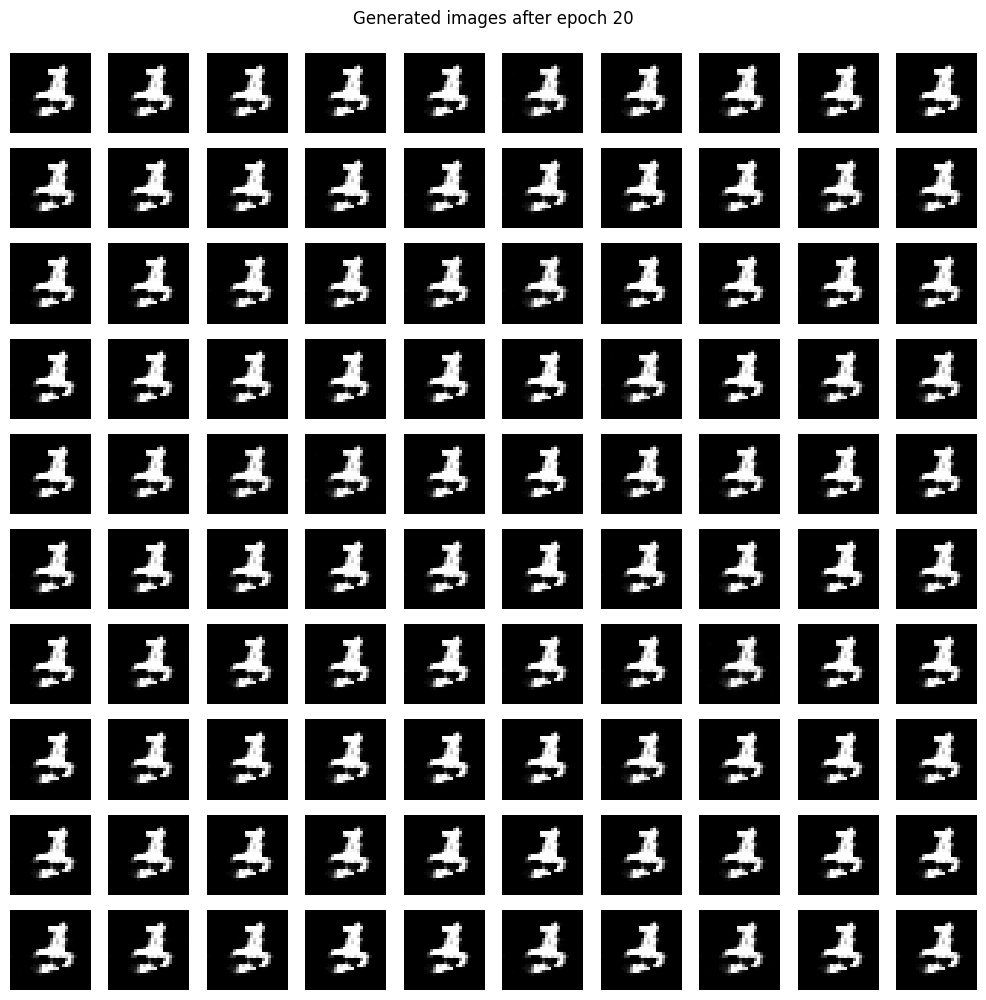


Epoch 21/50
Batch 400, D Loss: 0.9402, G Loss: 1.3271
Epoch 22/50
Batch 400, D Loss: 1.2000, G Loss: 1.0889
Epoch 23/50
Batch 400, D Loss: 0.4269, G Loss: 2.0155
Epoch 24/50
Batch 400, D Loss: 1.6189, G Loss: 0.8146
Epoch 25/50
Batch 400, D Loss: 1.2126, G Loss: 1.0826
Epoch 26/50
Batch 400, D Loss: 0.8515, G Loss: 1.3710
Epoch 27/50
Batch 400, D Loss: 1.2994, G Loss: 1.2606
Epoch 28/50
Batch 400, D Loss: 0.6375, G Loss: 1.9983
Epoch 29/50
Batch 400, D Loss: 0.7523, G Loss: 1.5285
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


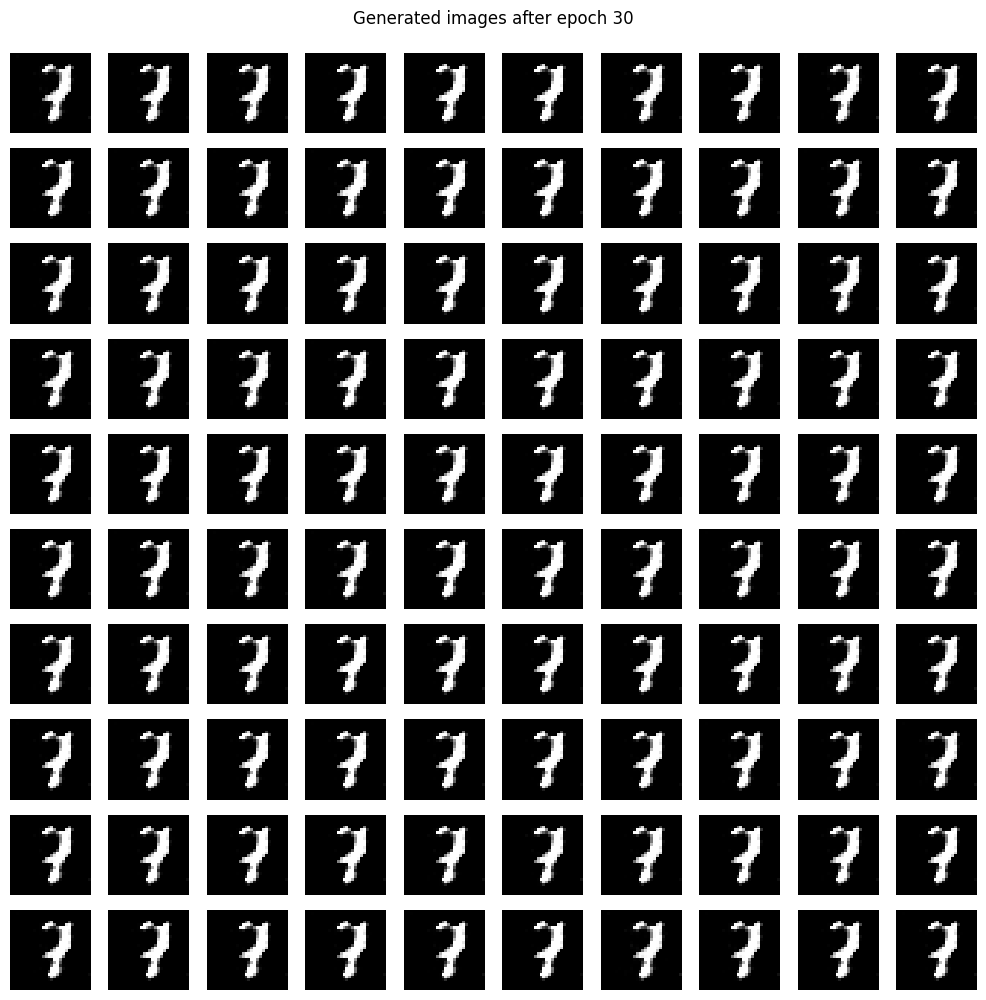


Epoch 31/50
Batch 400, D Loss: 0.7403, G Loss: 1.7872
Epoch 32/50
Batch 400, D Loss: 0.8629, G Loss: 1.8110
Epoch 33/50
Batch 400, D Loss: 0.8082, G Loss: 1.2659
Epoch 34/50
Batch 400, D Loss: 0.8201, G Loss: 1.5054
Epoch 35/50
Batch 400, D Loss: 0.5491, G Loss: 2.0074
Epoch 36/50
Batch 400, D Loss: 0.6470, G Loss: 2.0197
Epoch 37/50
Batch 400, D Loss: 1.1737, G Loss: 1.5199
Epoch 38/50
Batch 400, D Loss: 0.9659, G Loss: 1.5042
Epoch 39/50
Batch 400, D Loss: 0.5339, G Loss: 2.2463
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


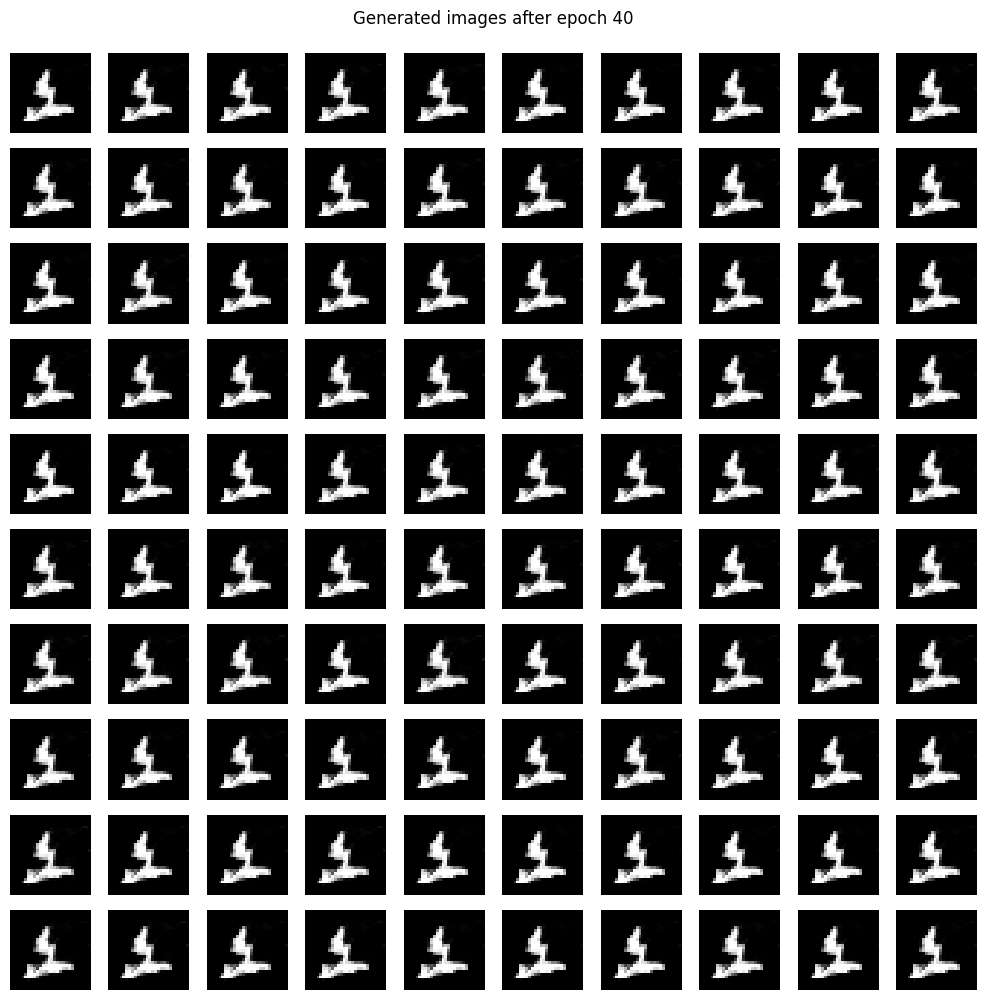


Epoch 41/50
Batch 400, D Loss: 0.6739, G Loss: 1.8932
Epoch 42/50
Batch 400, D Loss: 0.6520, G Loss: 2.0274
Epoch 43/50
Batch 400, D Loss: 0.4062, G Loss: 2.5327
Epoch 44/50
Batch 400, D Loss: 0.6752, G Loss: 2.0687
Epoch 45/50
Batch 400, D Loss: 1.1032, G Loss: 1.3631
Epoch 46/50
Batch 400, D Loss: 1.1581, G Loss: 1.4150
Epoch 47/50
Batch 400, D Loss: 0.3145, G Loss: 2.4339
Epoch 48/50
Batch 400, D Loss: 1.2887, G Loss: 0.7108
Epoch 49/50
Batch 400, D Loss: 0.6150, G Loss: 2.0607
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


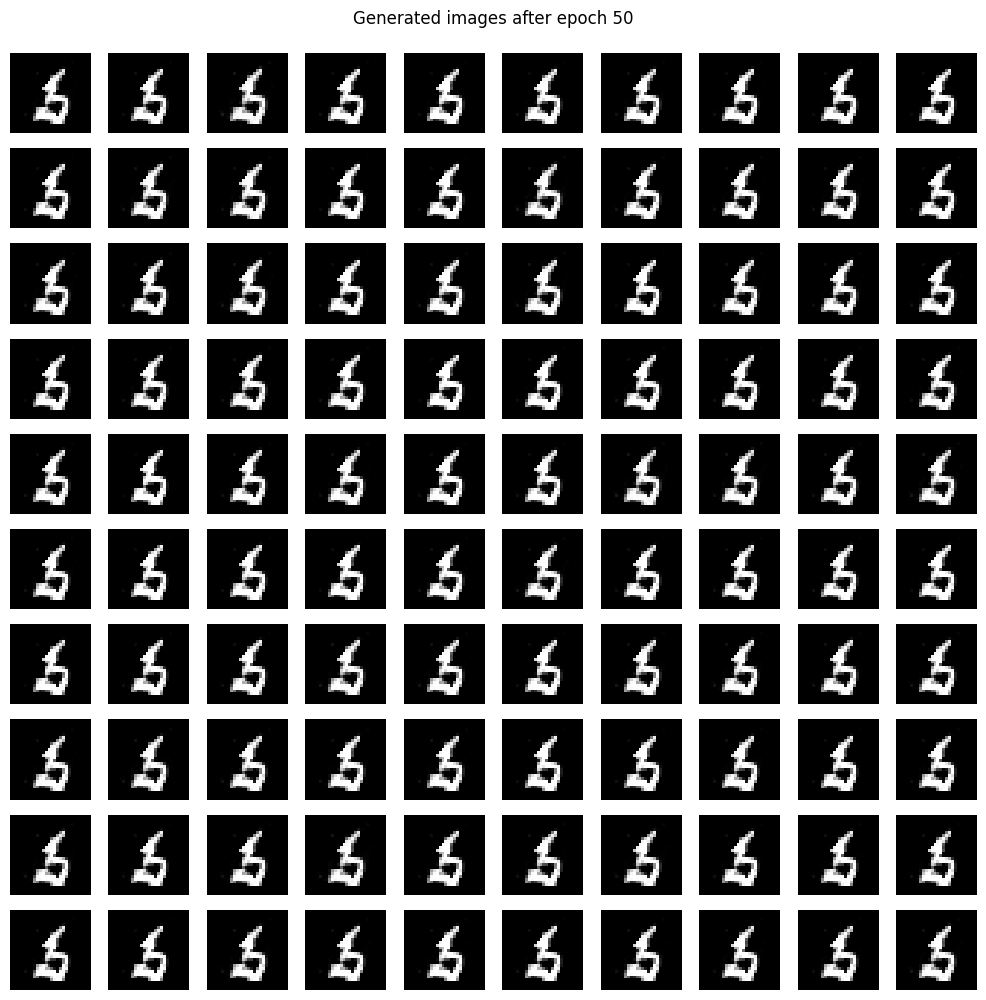

In [53]:
train(epochs=50, batch_size=128)

I changed the distribution as multiplied by 2 version

In [67]:
class GAN:
    def __init__(self):
        # Initialize models
        self.generator = create_generator()
        self.discriminator = create_discriminator_part1_conv2()

        # Initialize optimizers with mixed precision
        self.g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        self.d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

        # Loss function
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    @tf.function(reduce_retracing=True)
    def train_discriminator(self, real_images, batch_size):
        real_images = tf.cast(real_images, tf.float16)
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16) * 2.0

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Create labels
            real_labels = tf.ones_like(real_output)
            fake_labels = tf.zeros_like(fake_output)

            # Calculate losses
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            total_loss = real_loss + fake_loss

        # Calculate gradients
        gradients = tape.gradient(total_loss, self.discriminator.trainable_variables)

        # Apply gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        return total_loss

    @tf.function(reduce_retracing=True)
    def train_generator(self, batch_size):
        noise = tf.random.normal([batch_size, 100], dtype=tf.float16)

        with tf.GradientTape() as tape:
            # Generate fake images
            generated_images = self.generator(noise, training=True)

            # Get predictions
            fake_output = self.discriminator(generated_images, training=False)

            # Calculate loss
            labels = tf.ones_like(fake_output)
            loss = self.loss_fn(labels, fake_output)

        # Calculate gradients
        gradients = tape.gradient(loss, self.generator.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        return loss



def train(epochs=50, batch_size=128):
    # Load and prepare data
    x_train, _, _, _ = load_data()
    dataset_size = x_train.shape[0]

    # Create dataset with fixed shapes and types
    dataset = tf.data.Dataset.from_tensor_slices(x_train) \
        .shuffle(dataset_size) \
        .batch(batch_size, drop_remainder=True) \
        .prefetch(tf.data.AUTOTUNE)

    # Initialize GAN
    gan = GAN()

    # Training loop
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        for batch_idx, real_images in enumerate(dataset):
            d_loss = gan.train_discriminator(real_images, batch_size)
            g_loss = gan.train_generator(batch_size)

            if batch_idx % 100 == 0:
                print(f"\rBatch {batch_idx}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}", end="")

        # Generate and save images every 10 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_images(epoch + 1, gan.generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/50
Batch 400, D Loss: 0.7170, G Loss: 1.8472
Epoch 2/50
Batch 400, D Loss: 0.7387, G Loss: 2.8490
Epoch 3/50
Batch 400, D Loss: 0.4901, G Loss: 2.7979
Epoch 4/50
Batch 400, D Loss: 0.1927, G Loss: 4.0989
Epoch 5/50
Batch 400, D Loss: 0.2333, G Loss: 4.1336
Epoch 6/50
Batch 400, D Loss: 0.3189, G Loss: 4.2365
Epoch 7/50
Batch 400, D Loss: 0.3670, G Loss: 3.2471
Epoch 8/50
Batch 400, D Loss: 0.1590, G Loss: 3.8720
Epoch 9/50
Batch 400, D Loss: 0.3203, G Loss: 3.7165
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


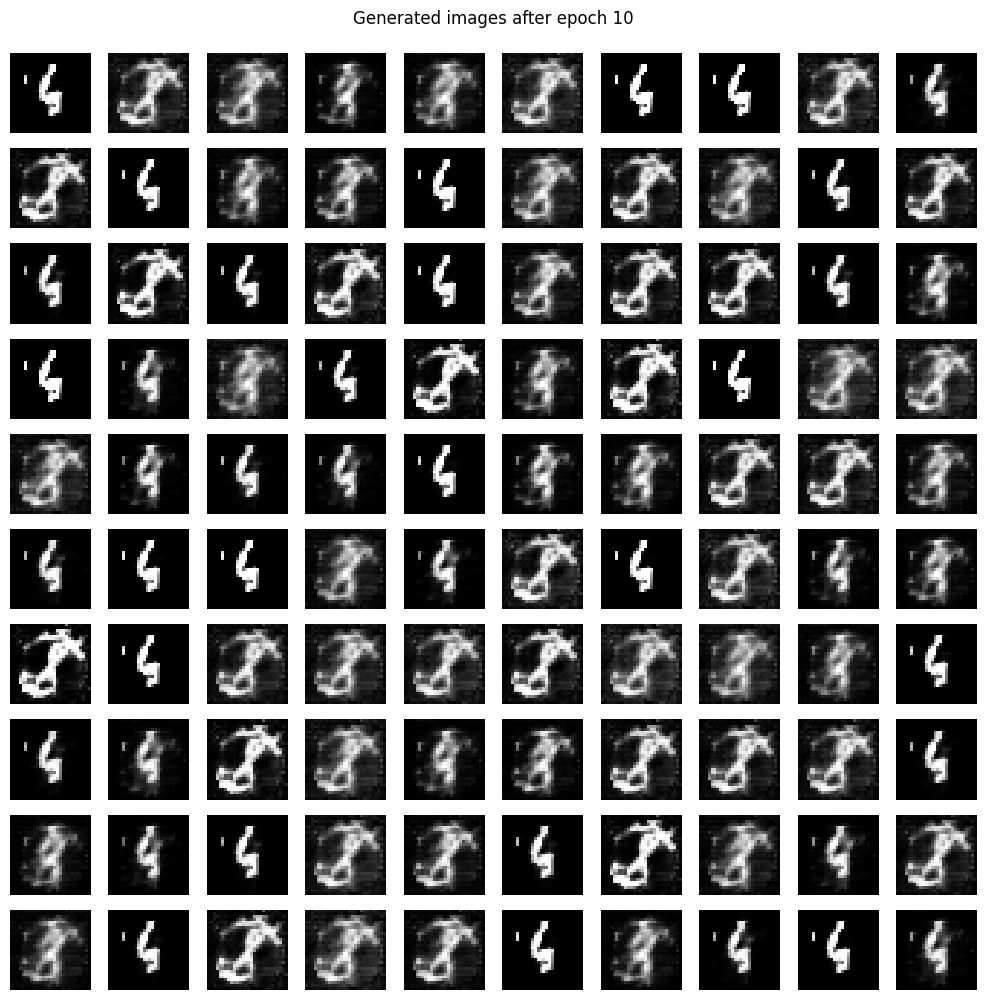


Epoch 11/50
Batch 400, D Loss: 0.2326, G Loss: 4.3641
Epoch 12/50
Batch 400, D Loss: 0.2093, G Loss: 4.8895
Epoch 13/50
Batch 400, D Loss: 0.1907, G Loss: 4.8312
Epoch 14/50
Batch 400, D Loss: 0.5033, G Loss: 3.9508
Epoch 15/50
Batch 400, D Loss: 0.2477, G Loss: 4.6949
Epoch 16/50
Batch 400, D Loss: 0.4225, G Loss: 4.1354
Epoch 17/50
Batch 400, D Loss: 0.2484, G Loss: 3.9679
Epoch 18/50
Batch 400, D Loss: 0.2250, G Loss: 4.5738
Epoch 19/50
Batch 400, D Loss: 0.3331, G Loss: 4.4814
Epoch 20/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


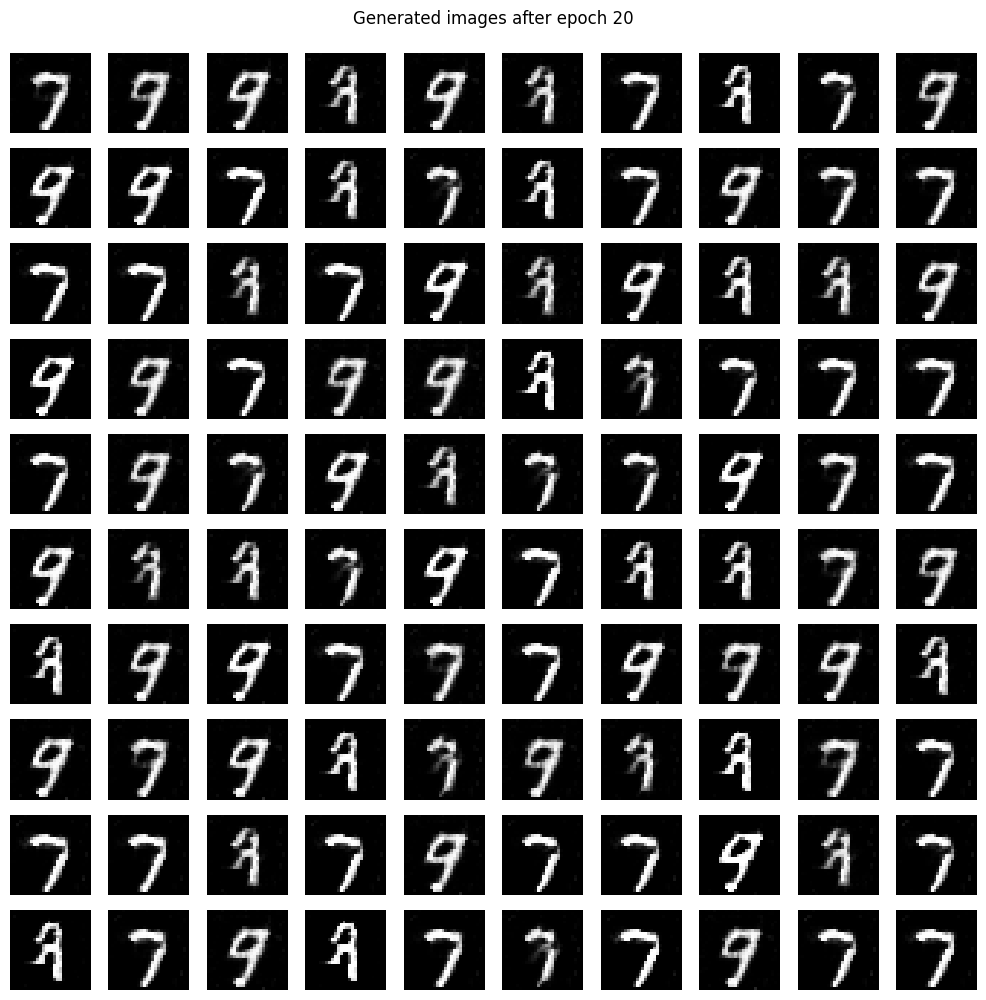


Epoch 21/50
Batch 400, D Loss: 0.2008, G Loss: 5.4173
Epoch 22/50
Batch 400, D Loss: 0.1161, G Loss: 4.7952
Epoch 23/50
Batch 400, D Loss: 0.3587, G Loss: 4.5666
Epoch 24/50
Batch 400, D Loss: 0.3587, G Loss: 2.8555
Epoch 25/50
Batch 400, D Loss: 0.2095, G Loss: 4.0845
Epoch 26/50
Batch 400, D Loss: 0.3077, G Loss: 3.3685
Epoch 27/50
Batch 400, D Loss: 0.3030, G Loss: 3.6043
Epoch 28/50
Batch 400, D Loss: 0.2056, G Loss: 3.5200
Epoch 29/50
Batch 400, D Loss: 0.3357, G Loss: 3.2301
Epoch 30/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


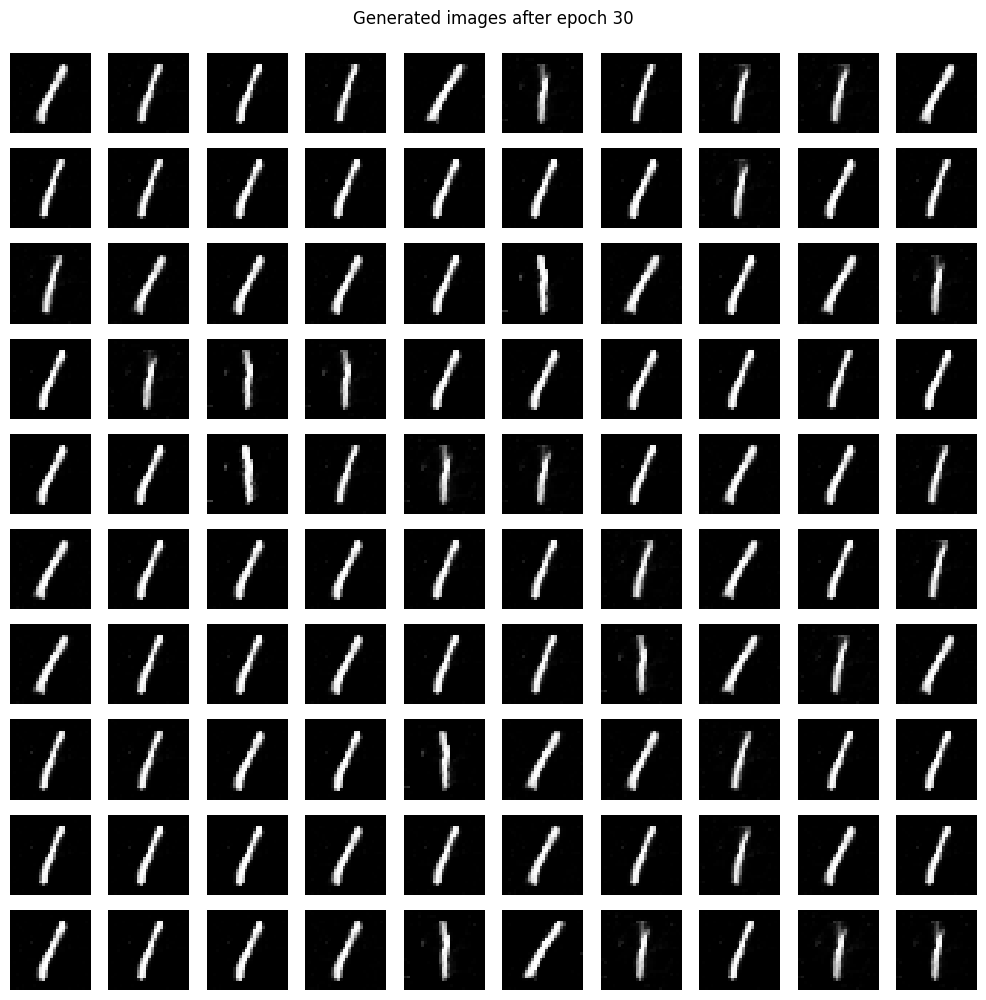


Epoch 31/50
Batch 400, D Loss: 0.2238, G Loss: 3.4577
Epoch 32/50
Batch 400, D Loss: 0.2175, G Loss: 3.2610
Epoch 33/50
Batch 400, D Loss: 0.2811, G Loss: 3.2871
Epoch 34/50
Batch 400, D Loss: 0.2068, G Loss: 4.7294
Epoch 35/50
Batch 400, D Loss: 0.1543, G Loss: 4.0565
Epoch 36/50
Batch 400, D Loss: 0.0884, G Loss: 4.1114
Epoch 37/50
Batch 400, D Loss: 0.2986, G Loss: 3.2197
Epoch 38/50
Batch 400, D Loss: 0.1239, G Loss: 4.3701
Epoch 39/50
Batch 400, D Loss: 0.1867, G Loss: 4.6585
Epoch 40/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


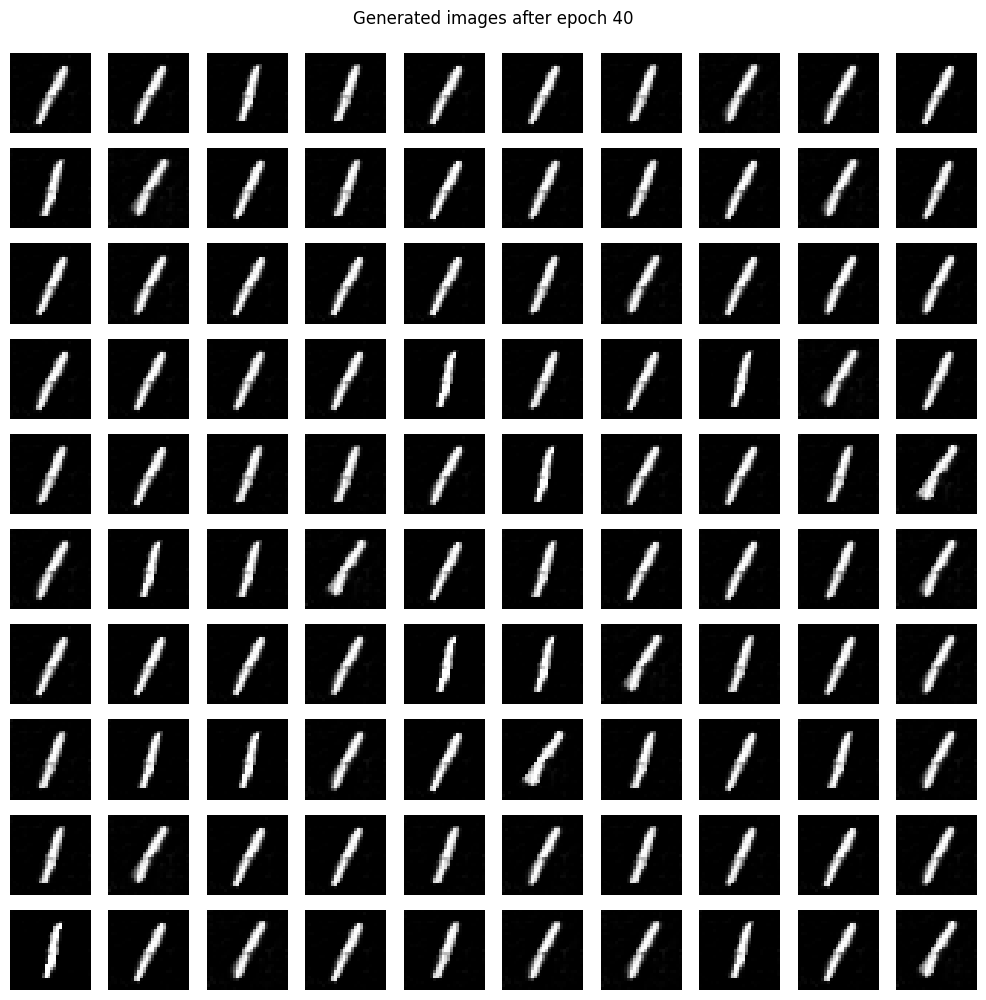


Epoch 41/50
Batch 400, D Loss: 0.1322, G Loss: 4.2213
Epoch 42/50
Batch 400, D Loss: 0.2326, G Loss: 4.0529
Epoch 43/50
Batch 400, D Loss: 0.2464, G Loss: 3.3201
Epoch 44/50
Batch 400, D Loss: 0.1392, G Loss: 3.8562
Epoch 45/50
Batch 400, D Loss: 0.1519, G Loss: 3.4028
Epoch 46/50
Batch 400, D Loss: 0.2352, G Loss: 3.0021
Epoch 47/50
Batch 400, D Loss: 0.2781, G Loss: 3.2815
Epoch 48/50
Batch 400, D Loss: 0.3191, G Loss: 2.5561
Epoch 49/50
Batch 400, D Loss: 0.3356, G Loss: 2.4688
Epoch 50/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


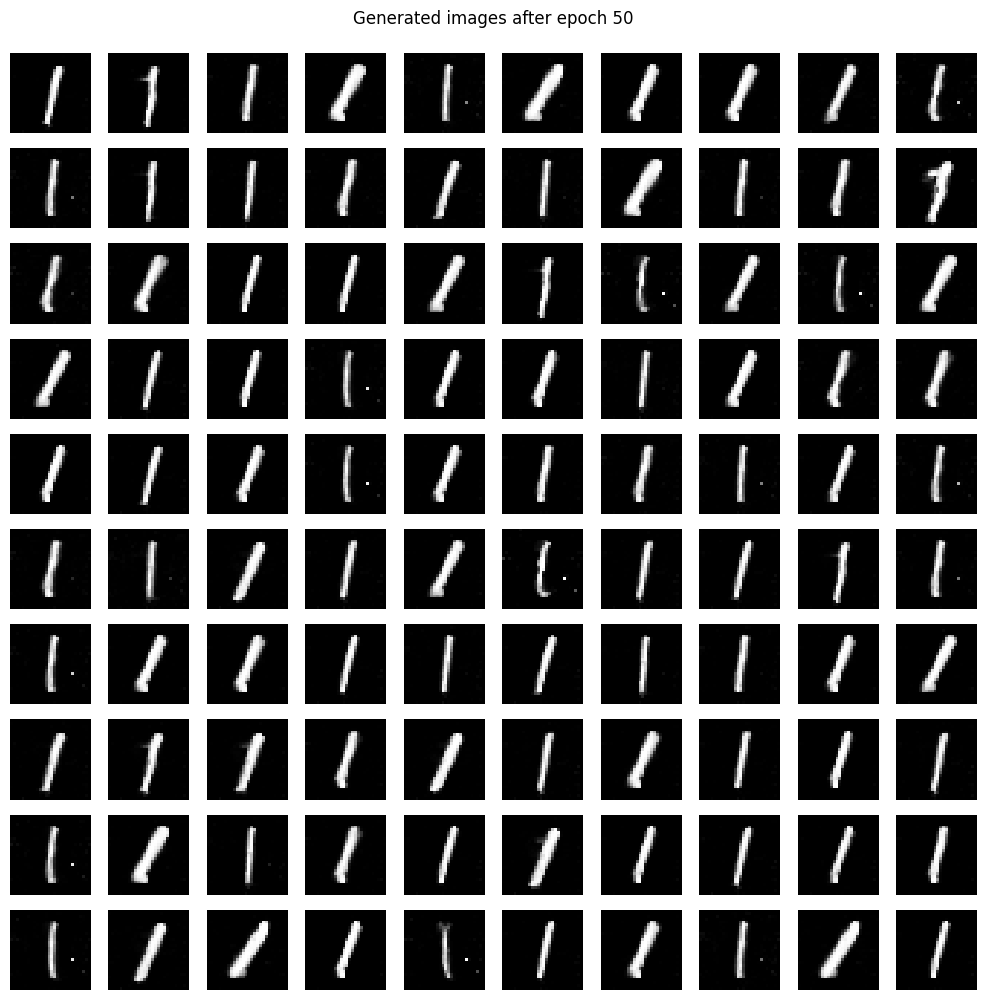

In [68]:
train(epochs=50, batch_size=128)